# Imports

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kendalltau, f_oneway
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import time
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder

# Load Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/walmart-sales-forecast


In [3]:
train_data = pd.read_csv('/kaggle/input/walmart-sales-forecast/train.csv')
stores_data = pd.read_csv('/kaggle/input/walmart-sales-forecast/stores.csv')
features_data = pd.read_csv('/kaggle/input/walmart-sales-forecast/features.csv')

print("Train shape:")
print(train_data.shape)
print("\nTrain head:")
print(train_data.head())
print("\nTrain Info:")
print(train_data.info())
print("\nTrain Stats:")
print(train_data.describe())

Train shape:
(421570, 5)

Train head:
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
None

Train Stats:
               Store           Dept   Weekly_Sales
count  421570.000000  421570.000000  421570.000000
mean       22.200546      

In [4]:
print("Stores shape:")
print(stores_data.shape)
print("\nStores head:")
print(stores_data.head())
print("\nStores Info:")
print(stores_data.info())
print("\nStores Stats:")
print(stores_data.describe())

Stores shape:
(45, 3)

Stores head:
   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

Stores Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB
None

Stores Stats:
           Store           Size
count  45.000000      45.000000
mean   23.000000  130287.600000
std    13.133926   63825.271991
min     1.000000   34875.000000
25%    12.000000   70713.000000
50%    23.000000  126512.000000
75%    34.000000  202307.000000
max    45.000000  219622.000000


In [5]:
print("Features shape:")
print(features_data.shape)
print("\nFeatures head:")
print(features_data.head())
print("\nFeatures Info:")
print(features_data.info())
print("\nFeatures Stats:")
print(features_data.describe())

Features shape:
(8190, 12)

Features head:
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False  

Features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8

# Data Preprocessing

In [6]:
Train_Stores_merge = train_data.merge(stores_data, on='Store', how='left')
print("Train_Stores_merge shape:")
print(Train_Stores_merge.shape)
print("\nTrain_Stores_merge head:")
print(Train_Stores_merge.head())

Train_Stores_merge shape:
(421570, 7)

Train_Stores_merge head:
   Store  Dept        Date  Weekly_Sales  IsHoliday Type    Size
0      1     1  2010-02-05      24924.50      False    A  151315
1      1     1  2010-02-12      46039.49       True    A  151315
2      1     1  2010-02-19      41595.55      False    A  151315
3      1     1  2010-02-26      19403.54      False    A  151315
4      1     1  2010-03-05      21827.90      False    A  151315


In [7]:
data = Train_Stores_merge.merge(features_data, on=['Store', 'Date'], how='left')

if (data['IsHoliday_x'] == data['IsHoliday_y']).all():
    print("IsHoliday_x and IsHoliday_y are identical, safe to drop one.")
else:
    print("Warning: IsHoliday_x and IsHoliday_y differ in some rows. Inspect before dropping.")

data = data.drop('IsHoliday_y', axis=1)

data = data.rename(columns={'IsHoliday_x': 'IsHoliday'})

print("\nData shape:")
print(data.shape)
print("\nData head:")
print(data.head())

IsHoliday_x and IsHoliday_y are identical, safe to drop one.

Data shape:
(421570, 16)

Data head:
   Store  Dept        Date  Weekly_Sales  IsHoliday Type    Size  Temperature  \
0      1     1  2010-02-05      24924.50      False    A  151315        42.31   
1      1     1  2010-02-12      46039.49       True    A  151315        38.51   
2      1     1  2010-02-19      41595.55      False    A  151315        39.93   
3      1     1  2010-02-26      19403.54      False    A  151315        46.63   
4      1     1  2010-03-05      21827.90      False    A  151315        46.50   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        NaN        NaN        NaN        NaN        NaN   
1       2.548        NaN        NaN        NaN        NaN        NaN   
2       2.514        NaN        NaN        NaN        NaN        NaN   
3       2.561        NaN        NaN        NaN        NaN        NaN   
4       2.625        NaN        NaN        NaN        

In [8]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Week'] = data['Date'].dt.isocalendar().week

data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,Week
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,5
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,2010,2,12,6
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,2010,2,19,7
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,2010,2,26,8
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,2010,3,5,9


In [9]:
data.isnull().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0
Type,0
Size,0
Temperature,0
Fuel_Price,0
MarkDown1,270889


In [10]:
data.describe()

,Store,Dept,Date,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,Week
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.0
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,2010.968591,6.449510,15.673131,25.826762
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,2010.000000,1.000000,1.000000,1.0
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,2010.000000,4.000000,8.000000,14.0
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,2011.000000,6.000000,16.000000,26.0
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,2012.000000,9.000000,23.000000,38.0
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,2012.000000,12.000000,31.000000,52.0
std,12.785297,30.492054,NaN,22711.183519,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,0.796876,3.243217,8.753549,14.151887


In [11]:
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
data[markdown_cols] = data[markdown_cols].fillna(0)

data.isnull().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0
Type,0
Size,0
Temperature,0
Fuel_Price,0
MarkDown1,0


In [12]:
data.duplicated().sum()

np.int64(0)

# Exploratory Data Analysis (EDA)

In [13]:
plt.style.use('default')
sns.set_palette("husl")

print("DATASET ANALYSIS\n")
print("Dataset Info:")
print(f"Shape: {data.shape}")
print(f"Columns: {list(data.columns)}")
print("\nColumn Types:")
print(data.dtypes)

if 'loan_id' in data.columns:
    data_clean = data.drop('loan_id', axis=1)
    print("Dropped 'loan_id' column")
else:
    data_clean = data.copy()
    print("No 'loan_id' column found, using all columns")

categorical_columns = []
numerical_columns = []

for col in data_clean.columns:
    if data_clean[col].dtype == 'object':
        categorical_columns.append(col)
    else:
        numerical_columns.append(col)

print(f"\nAuto-detected columns:")
print(f"Categorical columns ({len(categorical_columns)}): {categorical_columns}")
print(f"Numerical columns ({len(numerical_columns)}): {numerical_columns}")

DATASET ANALYSIS

Dataset Info:
Shape: (421570, 20)
Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Year', 'Month', 'Day', 'Week']

Column Types:
Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Type                    object
Size                     int64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Year                     int32
Month                    int32
Day                      int32
Week                    UInt32
dtype: object
No 'loan_id' column found, using all columns

Auto-detected columns:
C

Selected numerical columns: ['Store', 'Dept', 'Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']

NUMERICAL COLUMNS ANALYSIS


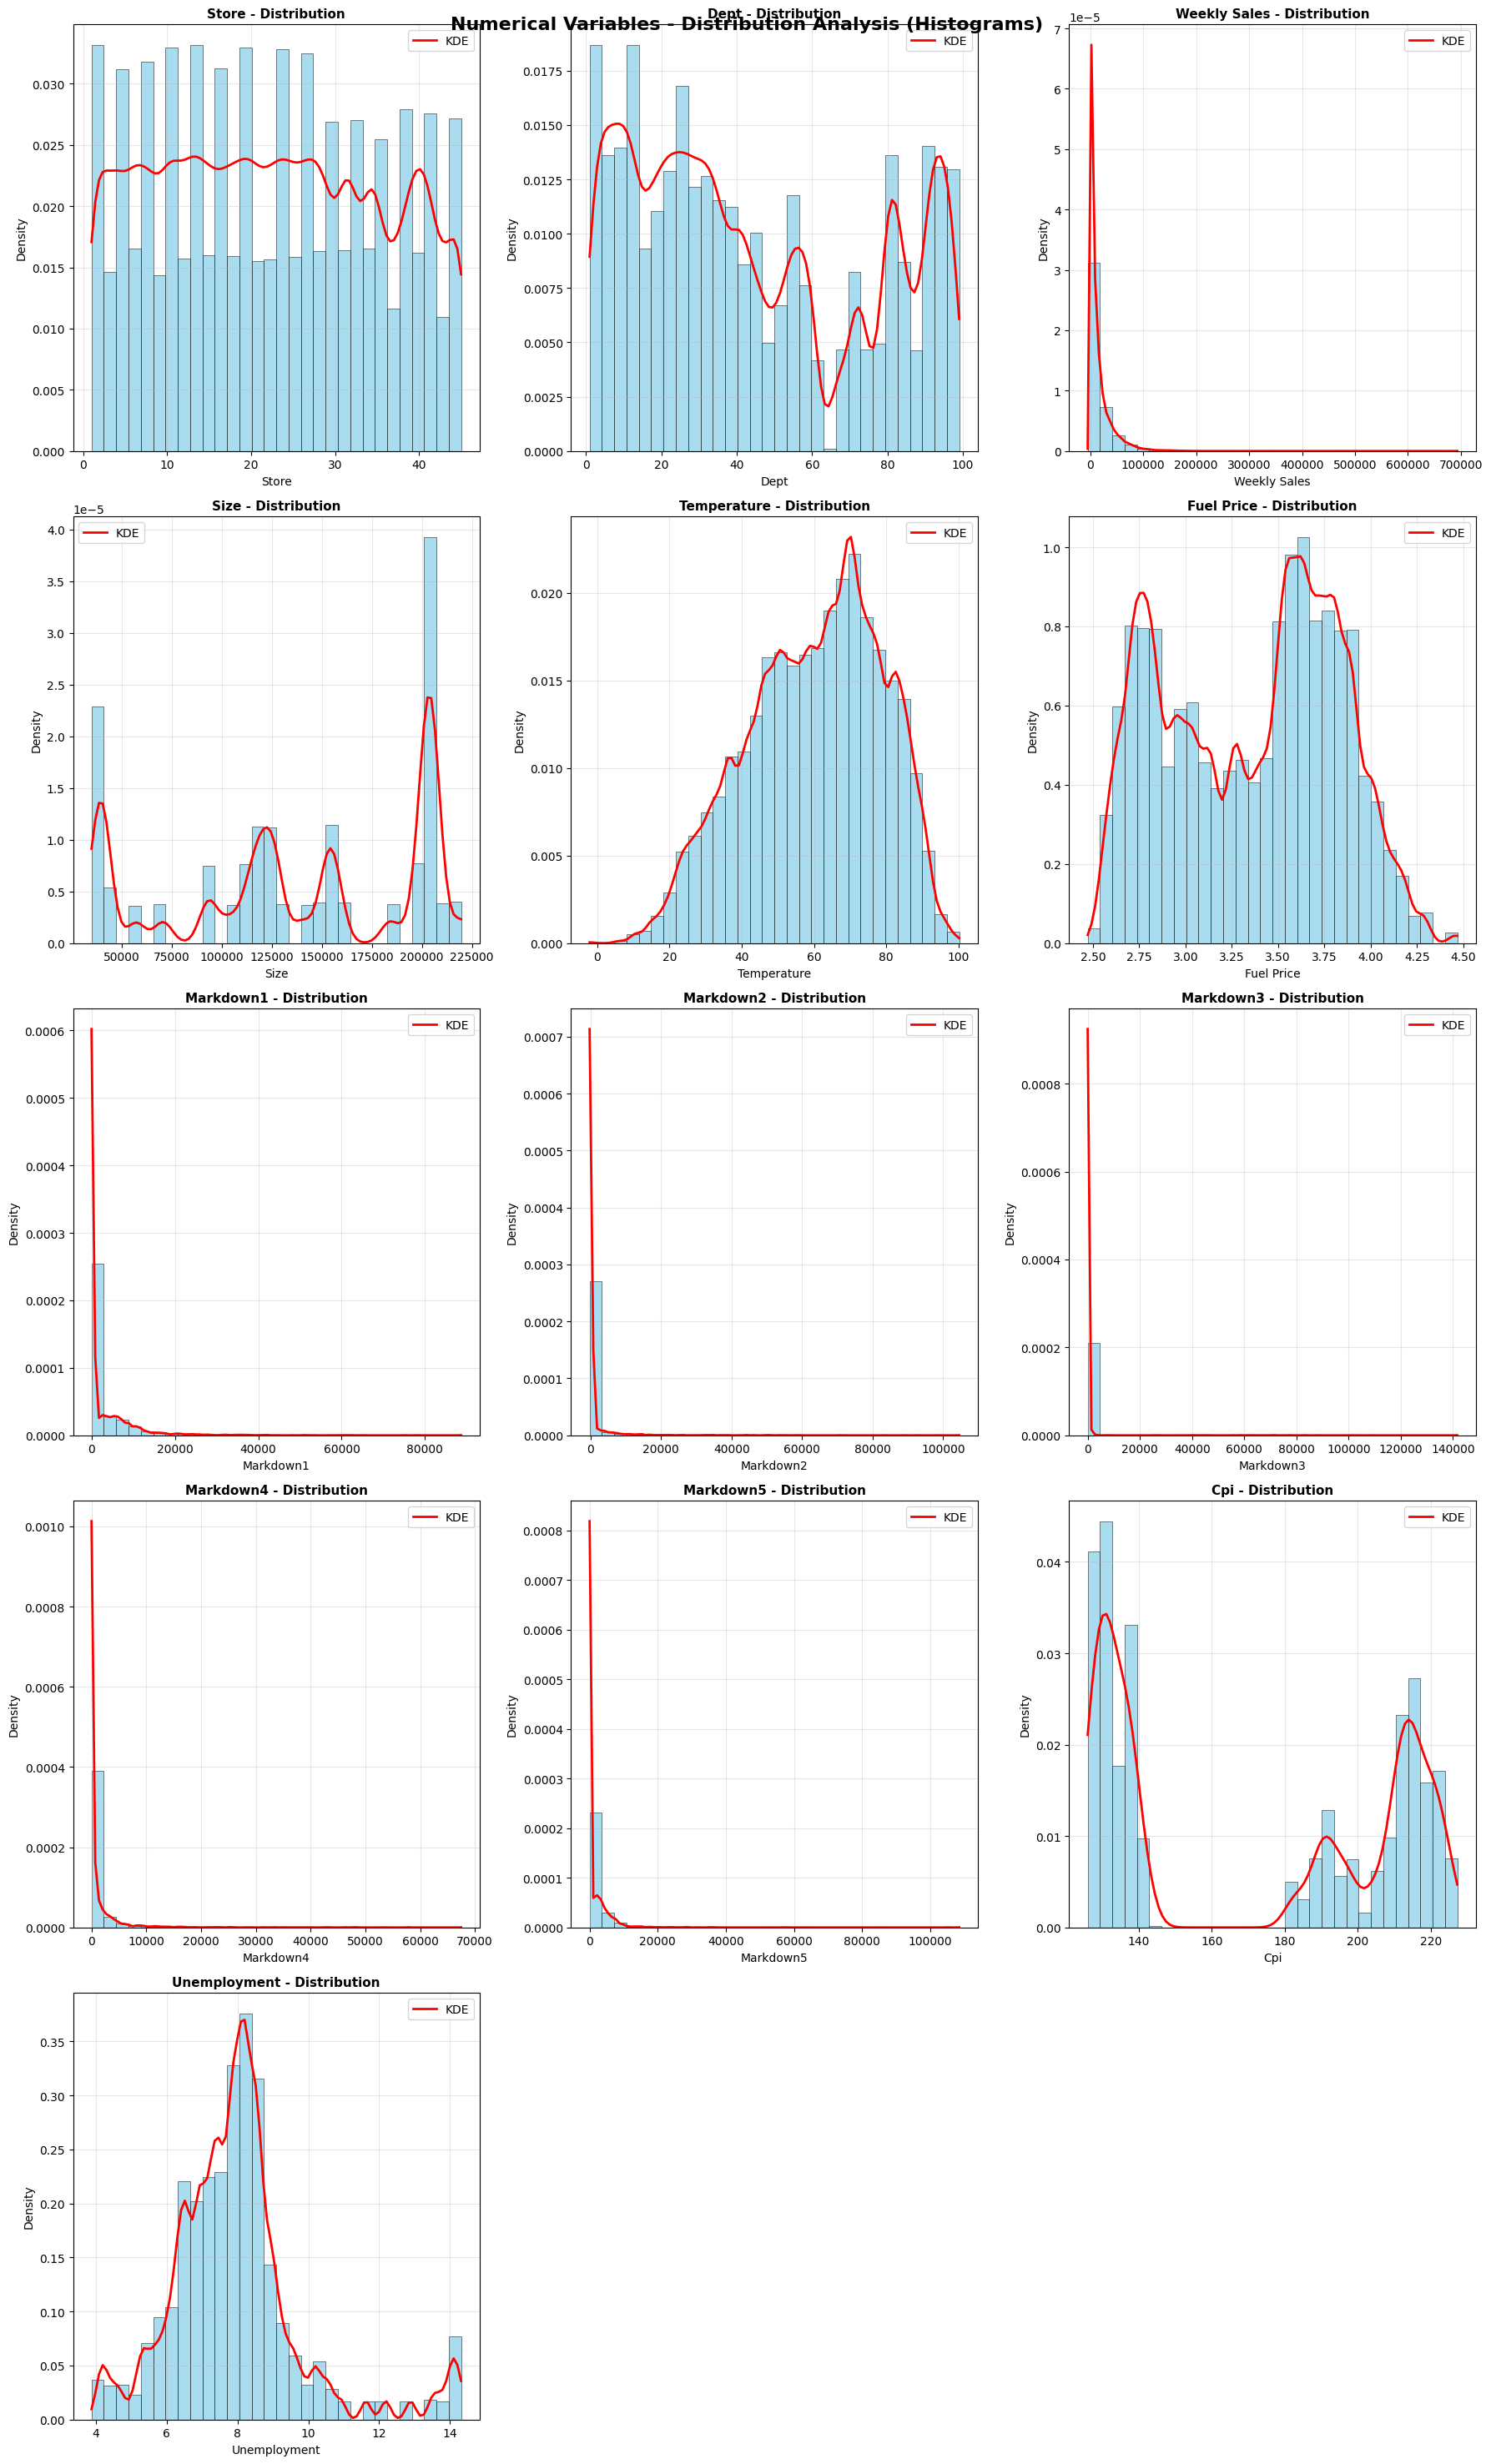

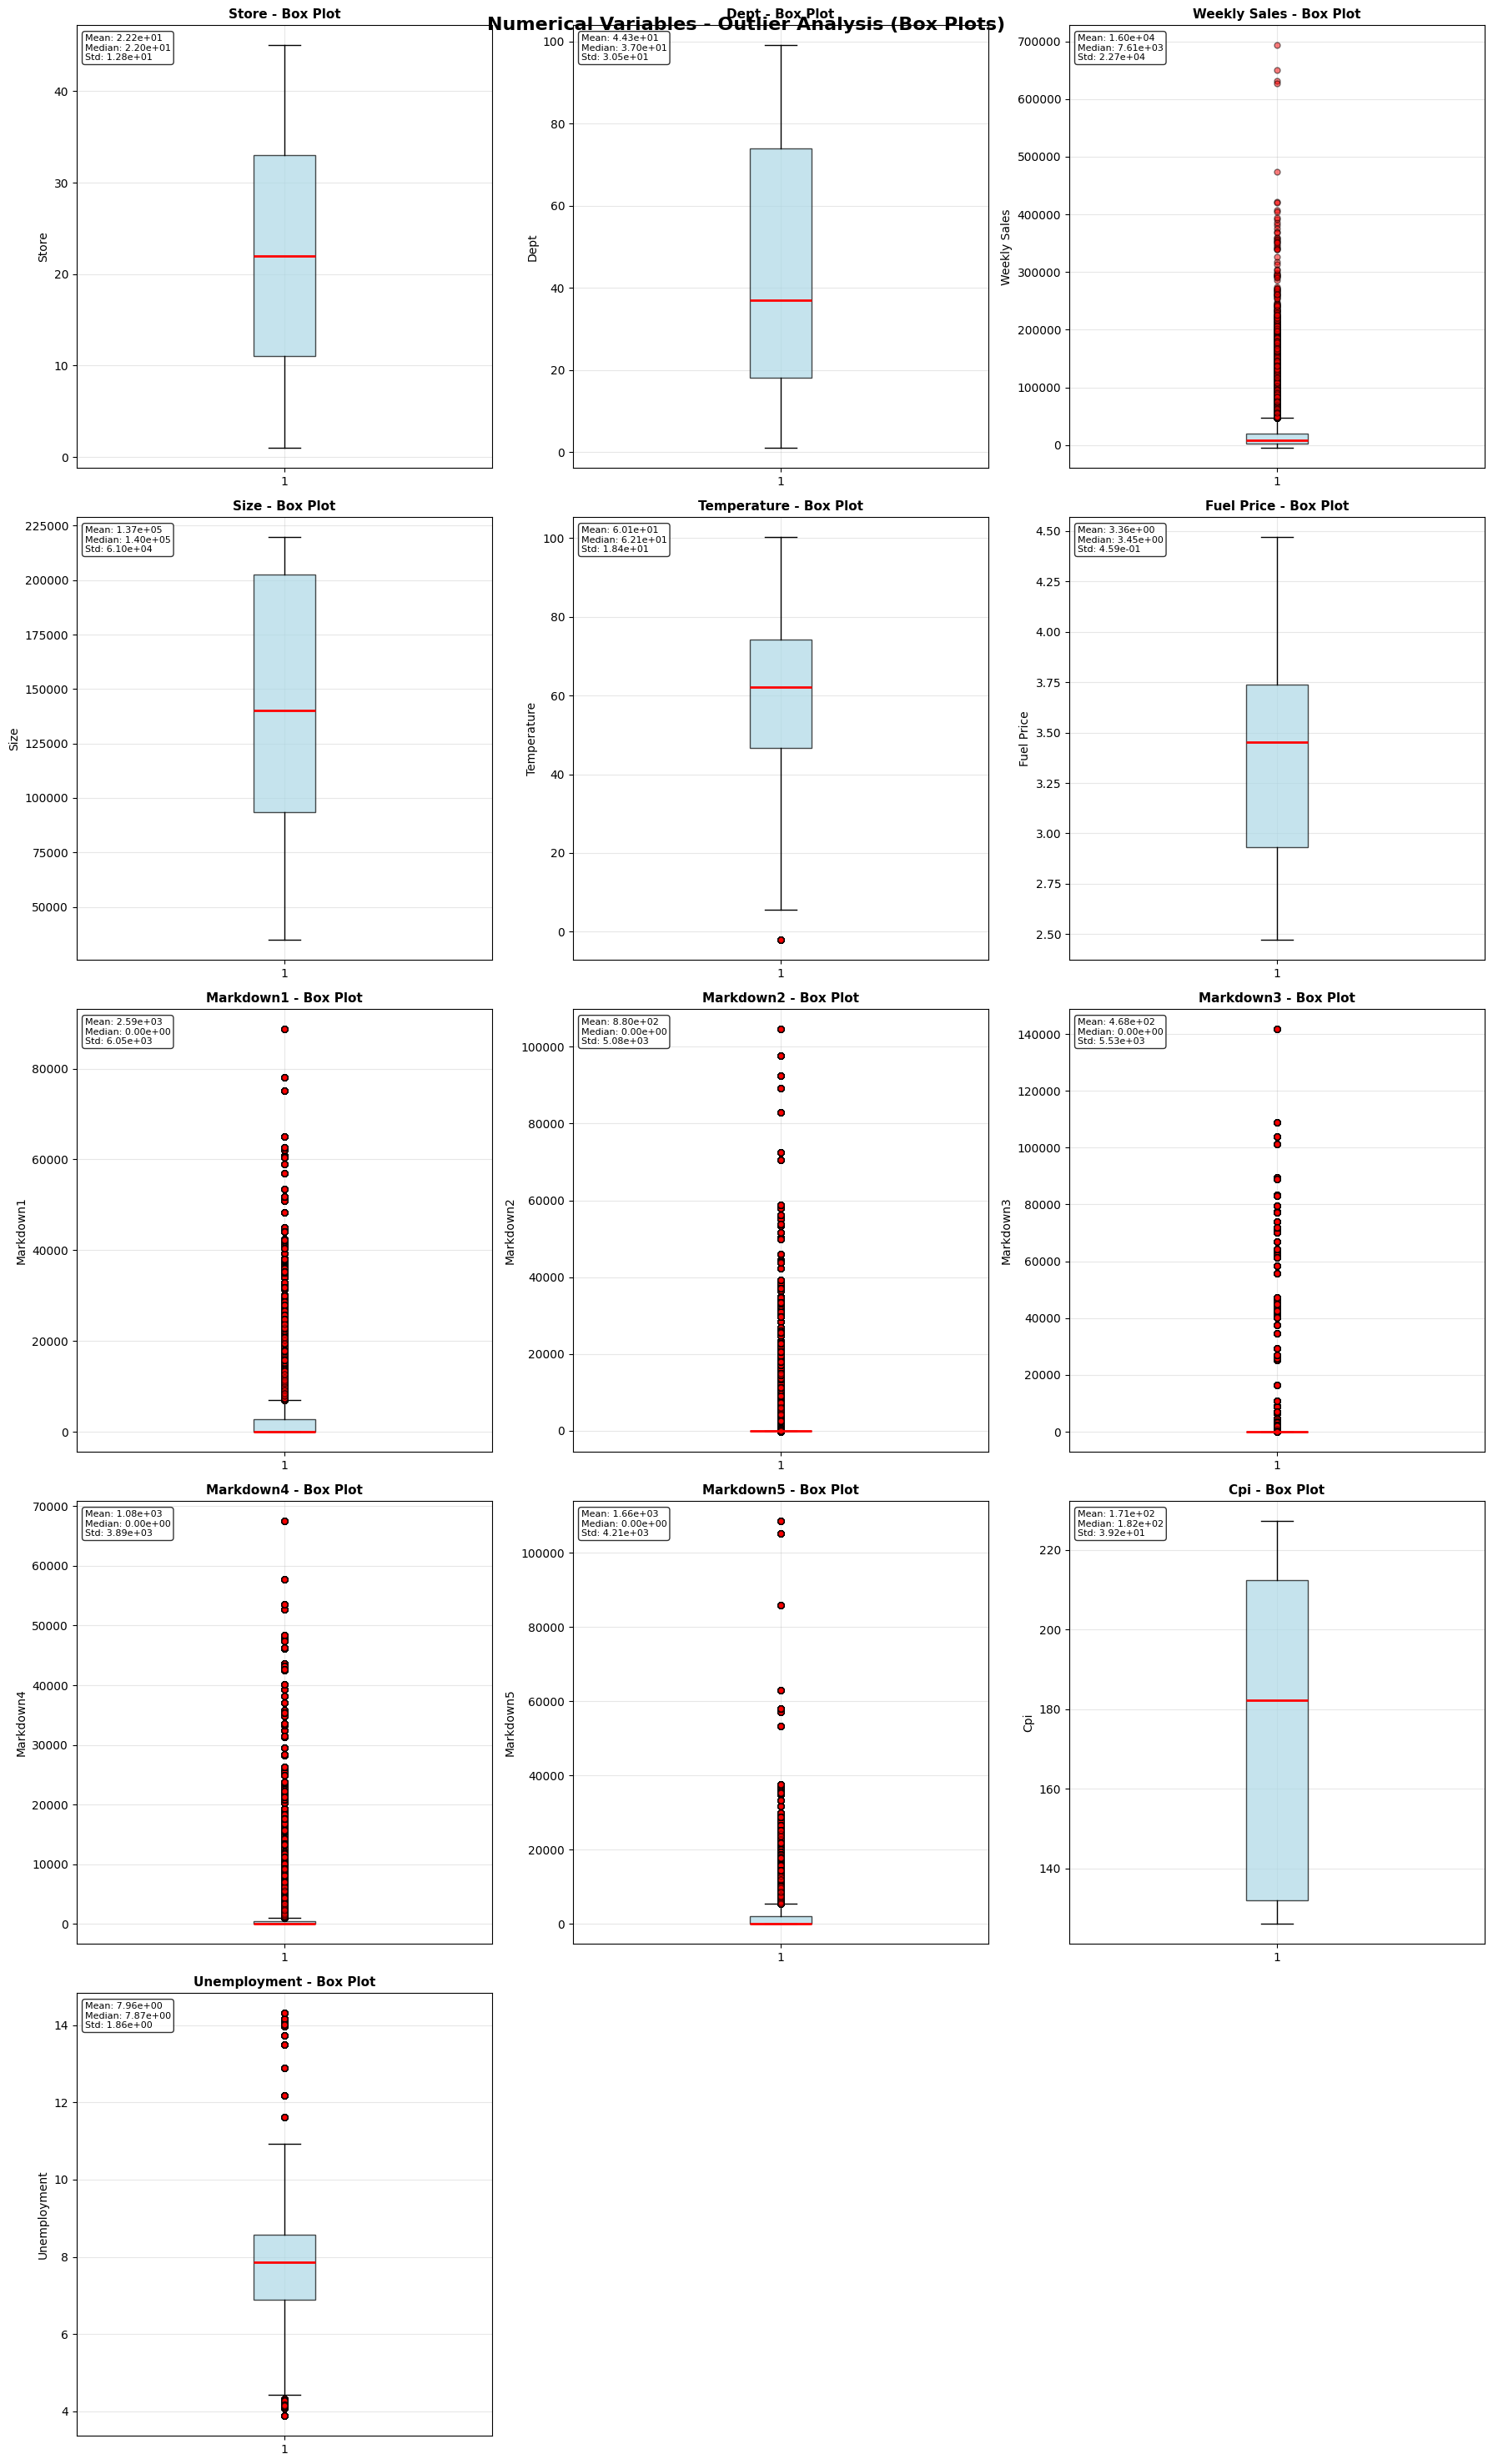


Numerical Variables Summary Statistics:
             Store      Dept  Weekly_Sales      Size  Temperature  Fuel_Price  \
count     4.22e+05  4.22e+05      4.22e+05  4.22e+05     4.22e+05    4.22e+05   
mean      2.22e+01  4.43e+01      1.60e+04  1.37e+05     6.01e+01    3.36e+00   
std       1.28e+01  3.05e+01      2.27e+04  6.10e+04     1.84e+01    4.59e-01   
min       1.00e+00  1.00e+00     -4.99e+03  3.49e+04    -2.06e+00    2.47e+00   
25%       1.10e+01  1.80e+01      2.08e+03  9.36e+04     4.67e+01    2.93e+00   
50%       2.20e+01  3.70e+01      7.61e+03  1.40e+05     6.21e+01    3.45e+00   
75%       3.30e+01  7.40e+01      2.02e+04  2.03e+05     7.43e+01    3.74e+00   
max       4.50e+01  9.90e+01      6.93e+05  2.20e+05     1.00e+02    4.47e+00   
skew      7.78e-02  3.58e-01      3.26e+00 -3.26e-01    -3.21e-01   -1.05e-01   
kurtosis -1.15e+00 -1.22e+00      2.15e+01 -1.21e+00    -6.36e-01   -1.19e+00   

          MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5    

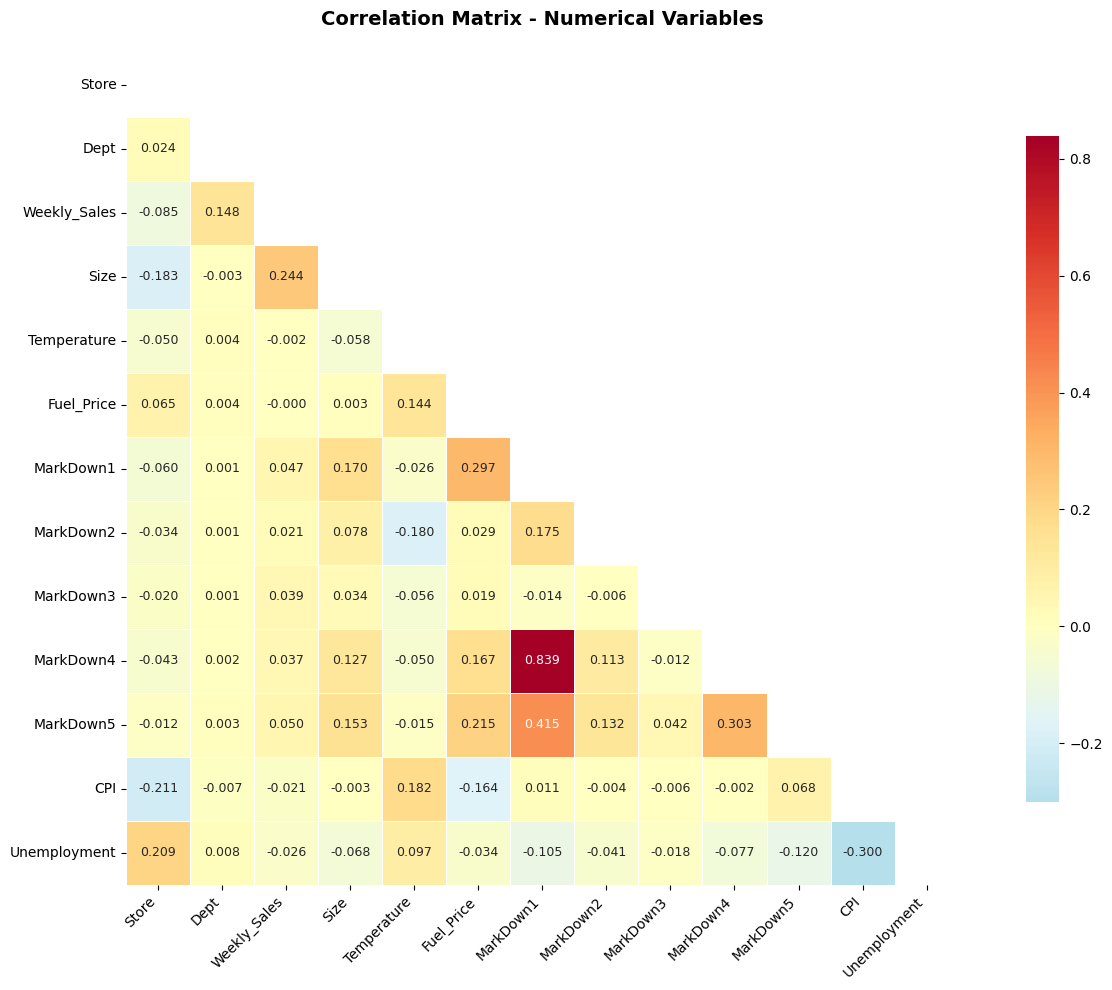

Highly Correlated Variable Pairs (|correlation| > 0.7):
  MarkDown1 ↔ MarkDown4: 0.839

VISUALIZATION COMPLETE!


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def format_col_name(col_name):
    """Helper function to format column names for display."""
    return col_name.title().replace("_", " ")

# Select numerical columns using a more direct pandas method
numerical_columns = data_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Selected numerical columns:", numerical_columns)

if numerical_columns: # Check if there are any numerical columns
    print("\nNUMERICAL COLUMNS ANALYSIS")

    n_num_cols = len(numerical_columns)
    # Define grid for subplots (3 columns per row)
    num_cols_grid = 3
    num_rows_grid = (n_num_cols + num_cols_grid - 1) // num_cols_grid # Ceiling division

    # --- Histograms and KDE Plots ---
    fig_hist, axes_hist = plt.subplots(num_rows_grid, num_cols_grid, figsize=(18, 6 * num_rows_grid))
    fig_hist.suptitle('Numerical Variables - Distribution Analysis (Histograms)',
                      fontsize=16, fontweight='bold', y=0.98)

    # Flatten axes for easy iteration, handles single subplot case too
    axes_hist = axes_hist.flatten()

    for i, col in enumerate(numerical_columns):
        ax = axes_hist[i] # Get the current axis

        # Plot histogram
        ax.hist(data_clean[col], bins=30, alpha=0.7, color='skyblue',
                density=True, edgecolor='black', linewidth=0.5)

        # Plot KDE (Kernel Density Estimate)
        try:
            kde_x = np.linspace(data_clean[col].min(), data_clean[col].max(), 100)
            kde = stats.gaussian_kde(data_clean[col])
            ax.plot(kde_x, kde(kde_x), color='red', linewidth=2, label='KDE')
        except Exception: # Catch any error during KDE calculation gracefully
            pass

        ax.set_title(f'{format_col_name(col)} - Distribution',
                     fontweight='bold', fontsize=11)
        ax.set_xlabel(format_col_name(col))
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)
        ax.legend()

    # Hide any unused subplots
    for i in range(n_num_cols, len(axes_hist)):
        axes_hist[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    # --- Box Plots ---
    fig_box, axes_box = plt.subplots(num_rows_grid, num_cols_grid, figsize=(18, 6 * num_rows_grid))
    fig_box.suptitle('Numerical Variables - Outlier Analysis (Box Plots)',
                     fontsize=16, fontweight='bold', y=0.98)

    axes_box = axes_box.flatten()

    for i, col in enumerate(numerical_columns):
        ax = axes_box[i]

        # Plot box plot
        ax.boxplot(data_clean[col], patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7, edgecolor='black'),
                   medianprops=dict(color='red', linewidth=2),
                   flierprops=dict(marker='o', markerfacecolor='red',
                                   markersize=5, alpha=0.5))

        ax.set_title(f'{format_col_name(col)} - Box Plot',
                     fontweight='bold', fontsize=11)
        ax.set_ylabel(format_col_name(col))
        ax.grid(True, alpha=0.3)

        # Display key statistics on the box plot
        mean_val = data_clean[col].mean()
        median_val = data_clean[col].median()
        std_val = data_clean[col].std()

        stats_text = f'Mean: {mean_val:.2e}\nMedian: {median_val:.2e}\nStd: {std_val:.2e}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round',
                facecolor='white', alpha=0.8), fontsize=8)

    # Hide any unused subplots
    for i in range(n_num_cols, len(axes_box)):
        axes_box[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    print("\nNumerical Variables Summary Statistics:")

    # Generate summary statistics and add skewness/kurtosis more concisely
    summary_stats = data_clean[numerical_columns].describe()
    additional_stats = data_clean[numerical_columns].agg(['skew', 'kurtosis'])
    full_summary = pd.concat([summary_stats, additional_stats])

    # Temporarily set display options for better readability of the summary table
    with pd.option_context('display.max_columns', None,
                           'display.width', None,
                           'display.float_format', '{:.2e}'.format):
        print(full_summary)

    # --- Correlation Analysis ---
    if len(numerical_columns) > 1:
        print("\nCORRELATION ANALYSIS")

        correlation_matrix = data_clean[numerical_columns].corr()

        plt.figure(figsize=(14, 10))
        # Create a mask for the upper triangle to avoid duplicate values
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r',
                              center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8},
                              fmt='.3f', annot_kws={'size': 9})
        plt.title('Correlation Matrix - Numerical Variables', fontweight='bold', fontsize=14, pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        print("Highly Correlated Variable Pairs (|correlation| > 0.7):")

        # Find highly correlated pairs more programmatically using stack()
        high_corr_pairs = correlation_matrix.stack()
        # Filter for correlations above the threshold (absolute value)
        high_corr_pairs = high_corr_pairs[abs(high_corr_pairs) > 0.7]
        # Filter out self-correlations and duplicate pairs (e.g., (A,B) and (B,A))
        high_corr_pairs = high_corr_pairs[high_corr_pairs.index.get_level_values(0) < high_corr_pairs.index.get_level_values(1)]

        if not high_corr_pairs.empty:
            for (var1, var2), corr_val in high_corr_pairs.items():
                print(f"  {var1} ↔ {var2}: {corr_val:.3f}")
        else:
            print("No highly correlated pairs found (threshold: |correlation| > 0.7)")

print("\nVISUALIZATION COMPLETE!")

# Feature Selection

In [15]:
numeric_cols = data.select_dtypes(include=['int64']).columns
skewness = data[numeric_cols].skew()
cols_to_log = skewness[abs(skewness) > 0.5].index
transformation_columns = [col for col in cols_to_log if col != 'loan_status']
print(f"Columns with skewness > 0.5: {cols_to_log.tolist()}" )

Columns with skewness > 0.5: []


In [16]:
for col in numerical_columns:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col]
    percent_outliers = (outliers.count() / data[col].count()) * 100
    print(f"{col}: {percent_outliers:.2f}% outliers")

Store: 0.00% outliers
Dept: 0.00% outliers
Weekly_Sales: 8.43% outliers
Size: 0.00% outliers
Temperature: 0.02% outliers
Fuel_Price: 0.00% outliers
MarkDown1: 13.23% outliers
MarkDown2: 24.47% outliers
MarkDown3: 20.09% outliers
MarkDown4: 18.77% outliers
MarkDown5: 9.60% outliers
CPI: 0.00% outliers
Unemployment: 7.62% outliers


In [17]:
data.dtypes

,0
Store,int64
Dept,int64
Date,datetime64[ns]
Weekly_Sales,float64
IsHoliday,bool
Type,object
Size,int64
Temperature,float64
Fuel_Price,float64
MarkDown1,float64


CORRELATION ANALYSIS WITH WEEKLY SALES
Dataset shape: (421570, 20)
Number of numeric features: 16

TOP 10 STRONGEST CORRELATIONS WITH WEEKLY_SALES:

Size           :  0.244 (Weak Positive)
Dept           :  0.148 (Weak Positive)
Store          : -0.085 (Weak Negative)
MarkDown5      :  0.050 (Weak Positive)
MarkDown1      :  0.047 (Weak Positive)
MarkDown3      :  0.039 (Weak Positive)
MarkDown4      :  0.037 (Weak Positive)
Month          :  0.028 (Weak Positive)
Week           :  0.028 (Weak Positive)
Unemployment   : -0.026 (Weak Negative)

WEAKEST CORRELATIONS (closest to 0):

Fuel_Price     : -0.000
Temperature    : -0.002
Day            : -0.006
Year           : -0.010
MarkDown2      :  0.021

STATISTICAL INSIGHTS
Weekly Sales - Mean: $15,981.26
Weekly Sales - Std:  $22,711.18
Weekly Sales - Min:  $-4,988.94
Weekly Sales - Max:  $693,099.36

MARKDOWN IMPACT ANALYSIS:

MarkDown1: Correlation=0.047, Avg=$2590.07
MarkDown2: Correlation=0.021, Avg=$879.97
MarkDown3: Correlation=0.039

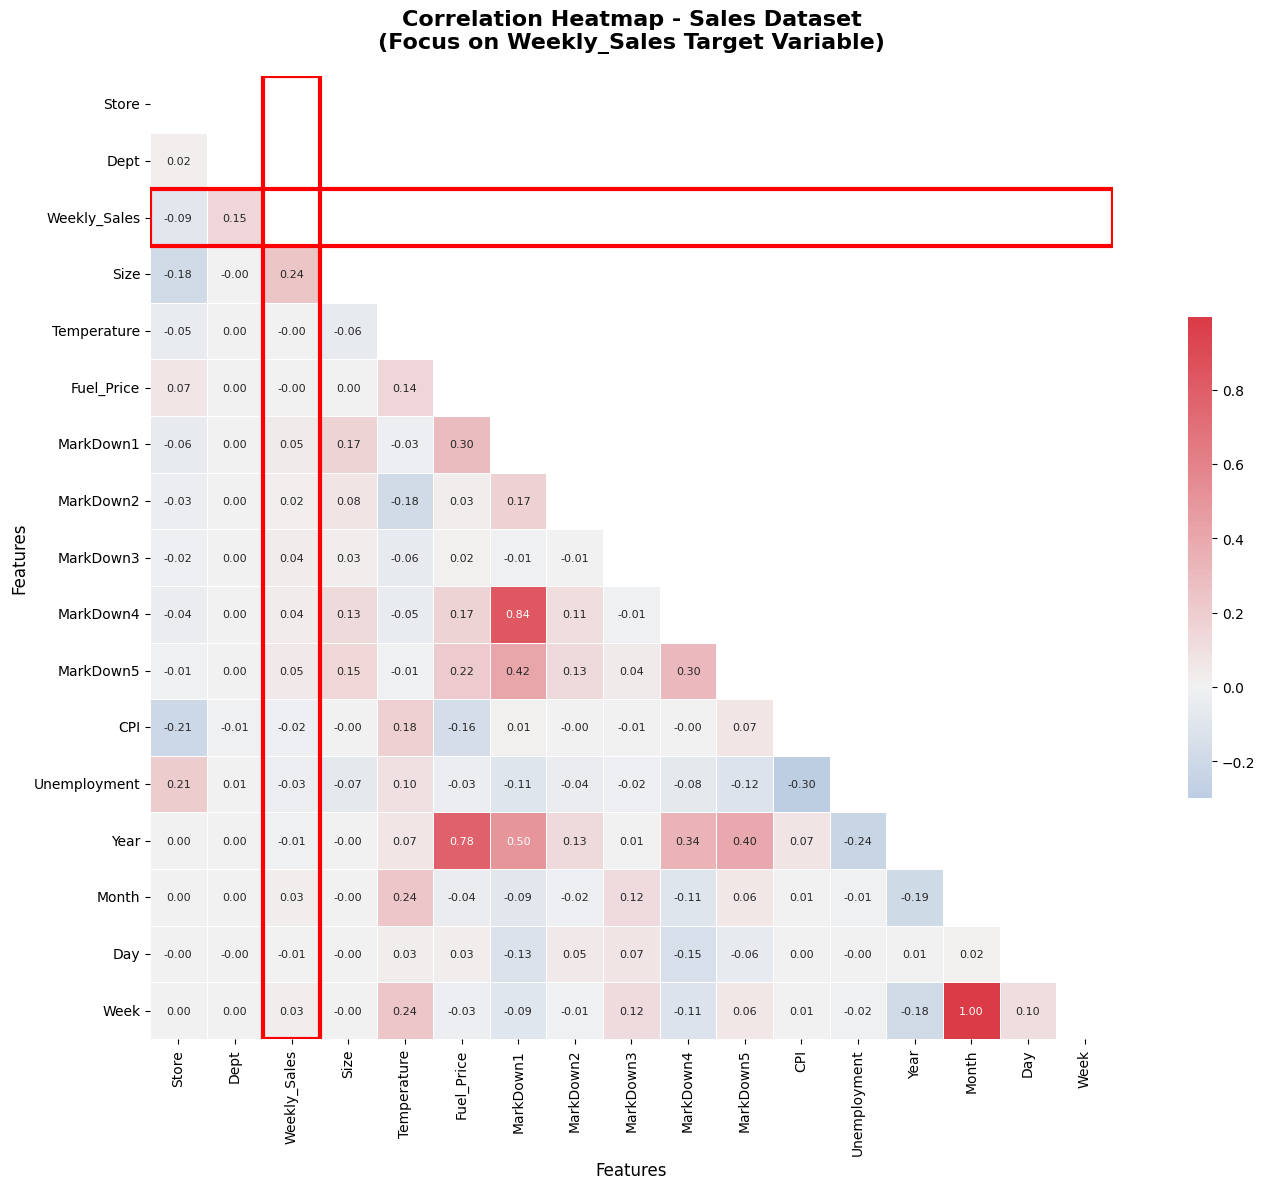

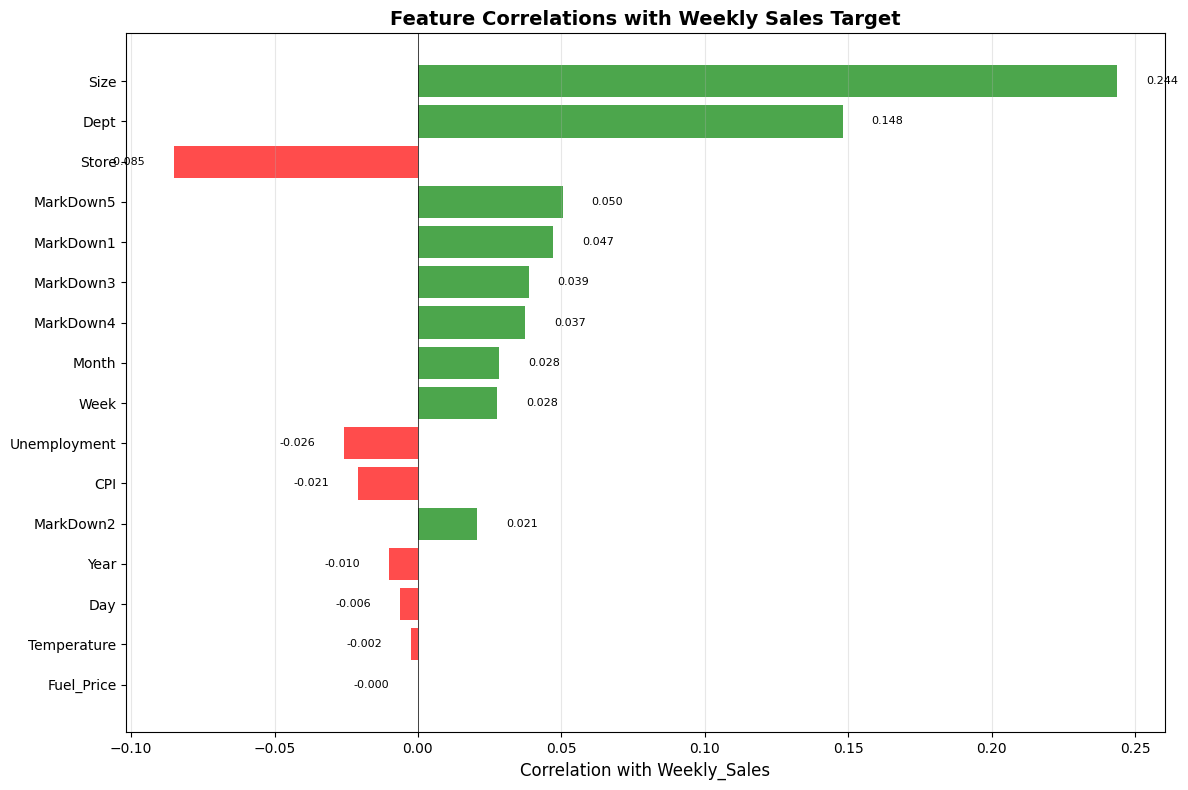


FEATURE IMPORTANCE INSIGHTS
No features show strong correlation (>0.5) with Weekly_Sales

DETAILED FEATURE ANALYSIS
Holiday Impact:
  - Holiday weeks avg sales: $17,035.82
  - Regular weeks avg sales: $15,901.45
  - Holiday impact: +7.1%


In [18]:
def analyze_sales_correlations(df):
    """
    Analyze correlations with Weekly_Sales target variable and create visualizations
    """

    # Select numeric columns for correlation analysis
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

    # Remove Date column if it exists in numeric form
    if 'Date' in numeric_columns:
        numeric_columns.remove('Date')

    # Calculate correlation matrix
    correlation_matrix = df[numeric_columns].corr()

    # Get correlations with Weekly_Sales
    target_correlations = correlation_matrix['Weekly_Sales'].sort_values(key=abs, ascending=False)

    print("CORRELATION ANALYSIS WITH WEEKLY SALES")
    print(f"Dataset shape: {df.shape}")
    print(f"Number of numeric features: {len(numeric_columns)-1}")  # -1 to exclude target
    print()

    # Print top positive and negative correlations
    print("TOP 10 STRONGEST CORRELATIONS WITH WEEKLY_SALES:\n")
    for feature, corr in target_correlations.head(11).items():  # 11 to include target itself
        if feature != 'Weekly_Sales':
            strength = "Strong" if abs(corr) > 0.7 else "Moderate" if abs(corr) > 0.5 else "Weak"
            direction = "Positive" if corr > 0 else "Negative"
            print(f"{feature:15s}: {corr:6.3f} ({strength} {direction})")

    print()
    print("WEAKEST CORRELATIONS (closest to 0):\n")
    weak_corrs = target_correlations[target_correlations.index != 'Weekly_Sales']
    weak_corrs_sorted = weak_corrs.reindex(weak_corrs.abs().sort_values().index)
    for feature, corr in weak_corrs_sorted.head(5).items():
        print(f"{feature:15s}: {corr:6.3f}")

    # Statistical insights
    print()
    print("STATISTICAL INSIGHTS")
    print(f"Weekly Sales - Mean: ${df['Weekly_Sales'].mean():,.2f}")
    print(f"Weekly Sales - Std:  ${df['Weekly_Sales'].std():,.2f}")
    print(f"Weekly Sales - Min:  ${df['Weekly_Sales'].min():,.2f}")
    print(f"Weekly Sales - Max:  ${df['Weekly_Sales'].max():,.2f}")

    # Lag analysis
    lag_features = [col for col in df.columns if col.startswith('Lag_')]
    if lag_features:
        print()
        print("LAG FEATURE ANALYSIS:")
        print("-" * 20)
        for lag_feature in sorted(lag_features):
            corr_val = correlation_matrix.loc['Weekly_Sales', lag_feature]
            print(f"{lag_feature}: {corr_val:.3f}")

    # Markdown analysis
    markdown_features = [col for col in df.columns if col.startswith('MarkDown')]
    if markdown_features:
        print()
        print("MARKDOWN IMPACT ANALYSIS:\n")
        for markdown in sorted(markdown_features):
            corr_val = correlation_matrix.loc['Weekly_Sales', markdown]
            avg_markdown = df[markdown].mean()
            print(f"{markdown}: Correlation={corr_val:.3f}, Avg=${avg_markdown:.2f}")

    # Seasonal analysis
    seasonal_features = ['Month_sin', 'Month_cos', 'Week_sin', 'Week_cos']
    seasonal_present = [col for col in seasonal_features if col in df.columns]
    if seasonal_present:
        print()
        print("SEASONAL PATTERN ANALYSIS:\n")
        for seasonal in seasonal_present:
            corr_val = correlation_matrix.loc['Weekly_Sales', seasonal]
            print(f"{seasonal}: {corr_val:.3f}")

    # Create the heatmap
    plt.figure(figsize=(16, 12))

    # Create a mask for the upper triangle to make it cleaner
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    # Custom colormap
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Create heatmap
    heatmap = sns.heatmap(correlation_matrix,
                         mask=mask,
                         annot=True,
                         cmap=cmap,
                         center=0,
                         square=True,
                         linewidths=0.5,
                         cbar_kws={"shrink": 0.5},
                         fmt='.2f',
                         annot_kws={'size': 8})

    plt.title('Correlation Heatmap - Sales Dataset\n(Focus on Weekly_Sales Target Variable)',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Features', fontsize=12)

    # Highlight the Weekly_Sales row and column
    ax = plt.gca()
    if 'Weekly_Sales' in correlation_matrix.columns:
        sales_idx = list(correlation_matrix.columns).index('Weekly_Sales')
        # Add rectangle around Weekly_Sales row/column
        ax.add_patch(plt.Rectangle((0, sales_idx), len(correlation_matrix.columns), 1,
                                 fill=False, edgecolor='red', lw=3))
        ax.add_patch(plt.Rectangle((sales_idx, 0), 1, len(correlation_matrix.columns),
                                 fill=False, edgecolor='red', lw=3))

    plt.tight_layout()
    plt.show()

    # Create a focused correlation plot for Weekly_Sales
    plt.figure(figsize=(12, 8))
    target_corr_df = target_correlations.drop('Weekly_Sales').to_frame('Correlation')
    target_corr_df['Abs_Correlation'] = target_corr_df['Correlation'].abs()
    target_corr_df = target_corr_df.sort_values('Abs_Correlation', ascending=True)

    # Color coding for positive/negative correlations
    colors = ['red' if x < 0 else 'green' for x in target_corr_df['Correlation']]

    plt.barh(range(len(target_corr_df)), target_corr_df['Correlation'], color=colors, alpha=0.7)
    plt.yticks(range(len(target_corr_df)), target_corr_df.index, fontsize=10)
    plt.xlabel('Correlation with Weekly_Sales', fontsize=12)
    plt.title('Feature Correlations with Weekly Sales Target', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.grid(axis='x', alpha=0.3)

    # Add correlation values as text on bars
    for i, v in enumerate(target_corr_df['Correlation']):
        plt.text(v + (0.01 if v >= 0 else -0.01), i, f'{v:.3f}',
                va='center', ha='left' if v >= 0 else 'right', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Feature importance insights
    print()
    print("FEATURE IMPORTANCE INSIGHTS")
    strong_features = target_correlations[abs(target_correlations) > 0.5]
    strong_features = strong_features.drop('Weekly_Sales')

    if len(strong_features) > 0:
        print(f"Found {len(strong_features)} features with strong correlation (>0.5):")
        for feature, corr in strong_features.items():
            print(f"  - {feature}: {corr:.3f}")
    else:
        print("No features show strong correlation (>0.5) with Weekly_Sales")

    moderate_features = target_correlations[(abs(target_correlations) > 0.3) &
                                          (abs(target_correlations) <= 0.5)]
    moderate_features = moderate_features.drop('Weekly_Sales', errors='ignore')

    if len(moderate_features) > 0:
        print(f"Found {len(moderate_features)} features with moderate correlation (0.3-0.5):")
        for feature, corr in moderate_features.items():
            print(f"  - {feature}: {corr:.3f}")

    return correlation_matrix, target_correlations


def detailed_feature_analysis(df):
    """
    Provide detailed analysis of key features
    """
    print()
    print("DETAILED FEATURE ANALYSIS")

    if 'Store_encoded' in df.columns:
        print(f"Store Analysis:")
        print(f"  - Number of unique stores: {df['Store_encoded'].nunique()}")
        print(f"  - Store encoding range: {df['Store_encoded'].min():.2f} to {df['Store_encoded'].max():.2f}")

    if 'Dept_encoded' in df.columns:
        print(f"Department Analysis:")
        print(f"  - Number of unique departments: {df['Dept_encoded'].nunique()}")
        print(f"  - Dept encoding range: {df['Dept_encoded'].min():.2f} to {df['Dept_encoded'].max():.2f}")

    if 'IsHoliday' in df.columns:
        holiday_sales = df[df['IsHoliday'] == 1]['Weekly_Sales'].mean()
        regular_sales = df[df['IsHoliday'] == 0]['Weekly_Sales'].mean()
        print(f"Holiday Impact:")
        print(f"  - Holiday weeks avg sales: ${holiday_sales:,.2f}")
        print(f"  - Regular weeks avg sales: ${regular_sales:,.2f}")
        print(f"  - Holiday impact: {((holiday_sales/regular_sales-1)*100):+.1f}%")

    type_cols = [col for col in df.columns if col.startswith('Type_')]
    if type_cols:
        print("Store Type Analysis:")
        for type_col in type_cols:
            type_sales = df[df[type_col] == True]['Weekly_Sales'].mean()
            print(f"  - {type_col} avg sales: ${type_sales:,.2f}")

correlation_matrix, target_correlations = analyze_sales_correlations(data)
detailed_feature_analysis(data)

In [19]:
def comprehensive_feature_selection(data, target_col='Weekly_Sales', significance_level=0.05):
    """
    Perform comprehensive feature selection using appropriate statistical tests
    """

    # Separate features from target
    X = data.drop(target_col, axis=1)
    y = data[target_col]

    print("COMPREHENSIVE FEATURE SELECTION ANALYSIS\n")
    print(f"Dataset shape: {data.shape}")
    print(f"Target variable: {target_col}")
    print(f"Significance level: {significance_level}")
    print()

    # Initialize results storage
    feature_results = {}

    # Identify feature types
    numerical_features = []
    categorical_features = []

    for col in X.columns:
        # Skip datetime columns
        if X[col].dtype.kind in ['M', 'm']:  # datetime64 and timedelta64
            print(f"Skipping datetime column: {col}")
            continue
        # Categorical features
        elif X[col].dtype in ['bool', 'object'] or col.startswith('Type_') or col == 'IsHoliday':
            categorical_features.append(col)
        # Numerical features
        else:
            numerical_features.append(col)

    print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
    print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
    print()

    # ===========================================
    # NUMERICAL FEATURES ANALYSIS
    # ===========================================

    print("NUMERICAL FEATURES ANALYSIS\n")
    print("Testing: Pearson's and Spearman's correlation")

    numerical_results = []

    for feature in numerical_features:
        # Pearson correlation
        pearson_corr, pearson_p = pearsonr(X[feature], y)

        # Spearman correlation
        spearman_corr, spearman_p = spearmanr(X[feature], y)

        # Store results
        result = {
            'Feature': feature,
            'Feature_Type': 'Numerical',
            'Pearson_Corr': pearson_corr,
            'Pearson_p_value': pearson_p,
            'Spearman_Corr': spearman_corr,
            'Spearman_p_value': spearman_p,
            'Pearson_Significant': pearson_p < significance_level,
            'Spearman_Significant': spearman_p < significance_level,
            'Max_Abs_Corr': max(abs(pearson_corr), abs(spearman_corr))
        }

        numerical_results.append(result)
        feature_results[feature] = result

        # Print results
        pearson_sig = "***" if pearson_p < 0.001 else "**" if pearson_p < 0.01 else "*" if pearson_p < 0.05 else ""
        spearman_sig = "***" if spearman_p < 0.001 else "**" if spearman_p < 0.01 else "*" if spearman_p < 0.05 else ""

        print(f"{feature:15s}: Pearson={pearson_corr:6.3f}{pearson_sig:3s} (p={pearson_p:.3e})")
        print(f"{'':15s}  Spearman={spearman_corr:6.3f}{spearman_sig:3s} (p={spearman_p:.3e})")
        print()

    # ===========================================
    # CATEGORICAL FEATURES ANALYSIS
    # ===========================================

    print("CATEGORICAL FEATURES ANALYSIS\n")
    print("Testing: ANOVA F-test and Kendall's Tau")

    categorical_results = []

    for feature in categorical_features:
        try:
            # Get unique values/groups
            unique_vals = X[feature].unique()
            groups = [y[X[feature] == val] for val in unique_vals]

            # Remove empty groups
            groups = [group for group in groups if len(group) > 0]

            if len(groups) < 2:
                print(f"{feature:15s}: Skipped - insufficient groups")
                continue

            # ANOVA F-test
            f_stat, anova_p = f_oneway(*groups)

            # Kendall's Tau (treat categorical as ordinal for this test)
            kendall_corr, kendall_p = kendalltau(X[feature].astype(float), y)

            # Store results
            result = {
                'Feature': feature,
                'Feature_Type': 'Categorical',
                'ANOVA_F_stat': f_stat,
                'ANOVA_p_value': anova_p,
                'Kendall_Tau': kendall_corr,
                'Kendall_p_value': kendall_p,
                'ANOVA_Significant': anova_p < significance_level,
                'Kendall_Significant': kendall_p < significance_level,
                'Max_Abs_Corr': abs(kendall_corr)
            }

            categorical_results.append(result)
            feature_results[feature] = result

            # Print results
            anova_sig = "***" if anova_p < 0.001 else "**" if anova_p < 0.01 else "*" if anova_p < 0.05 else ""
            kendall_sig = "***" if kendall_p < 0.001 else "**" if kendall_p < 0.01 else "*" if kendall_p < 0.05 else ""

            print(f"{feature:15s}: ANOVA F={f_stat:6.2f}{anova_sig:3s} (p={anova_p:.3e})")
            print(f"{'':15s}  Kendall τ={kendall_corr:6.3f}{kendall_sig:3s} (p={kendall_p:.3e})")
            print()

        except Exception as e:
            print(f"{feature:15s}: Error in analysis - {str(e)}")
            continue

    # ===========================================
    # SUMMARY AND RANKINGS
    # ===========================================

    print("FEATURE IMPORTANCE SUMMARY")

    # Create comprehensive results DataFrame
    all_results = []
    for feature, result in feature_results.items():
        if result['Feature_Type'] == 'Numerical':
            all_results.append({
                'Feature': feature,
                'Type': 'Numerical',
                'Primary_Score': abs(result['Pearson_Corr']),
                'Secondary_Score': abs(result['Spearman_Corr']),
                'Primary_p_value': result['Pearson_p_value'],
                'Secondary_p_value': result['Spearman_p_value'],
                'Primary_Significant': result['Pearson_Significant'],
                'Secondary_Significant': result['Spearman_Significant'],
                'Overall_Score': result['Max_Abs_Corr']
            })
        else:
            all_results.append({
                'Feature': feature,
                'Type': 'Categorical',
                'Primary_Score': result['ANOVA_F_stat'],
                'Secondary_Score': abs(result['Kendall_Tau']),
                'Primary_p_value': result['ANOVA_p_value'],
                'Secondary_p_value': result['Kendall_p_value'],
                'Primary_Significant': result['ANOVA_Significant'],
                'Secondary_Significant': result['Kendall_Significant'],
                'Overall_Score': result['Max_Abs_Corr']
            })

    results_df = pd.DataFrame(all_results)

    # Sort by overall importance
    results_df = results_df.sort_values('Overall_Score', ascending=False)

    print("\nTOP 15 MOST IMPORTANT FEATURES:")
    print("-" * 70)
    print(f"{'Rank':<4} {'Feature':<15} {'Type':<11} {'Score':<8} {'Significant':<12}")
    print("-" * 70)

    for i, (_, row) in enumerate(results_df.head(15).iterrows(), 1):
        sig_status = "Yes" if (row['Primary_Significant'] or row['Secondary_Significant']) else "No"
        print(f"{i:<4} {row['Feature']:<15} {row['Type']:<11} {row['Overall_Score']:<8.3f} {sig_status:<12}")

    # Statistical significance summary
    significant_features = results_df[
        (results_df['Primary_Significant']) | (results_df['Secondary_Significant'])
    ]

    print(f"\nSTATISTICAL SIGNIFICANCE SUMMARY:")
    print(f"Total features analyzed: {len(results_df)}")
    print(f"Statistically significant features: {len(significant_features)}")
    print(f"Non-significant features: {len(results_df) - len(significant_features)}")

    # Feature selection recommendations
    print(f"\nFEATURE SELECTION RECOMMENDATIONS")

    # High importance features (top quartile)
    high_importance = results_df.head(max(1, len(results_df)//4))
    print(f"HIGH IMPORTANCE ({len(high_importance)} features):")
    for feature in high_importance['Feature'].values:
        print(f"  - {feature}")

    # Medium importance features
    medium_start = len(results_df)//4
    medium_end = len(results_df)//2
    medium_importance = results_df.iloc[medium_start:medium_end]
    if len(medium_importance) > 0:
        print(f"\nMEDIUM IMPORTANCE ({len(medium_importance)} features):")
        for feature in medium_importance['Feature'].values:
            print(f"  - {feature}")

    # Low importance features
    low_importance = results_df.tail(len(results_df)//2)
    if len(low_importance) > 0:
        print(f"\nLOW IMPORTANCE ({len(low_importance)} features - consider removing):")
        for feature in low_importance['Feature'].values:
            print(f"  - {feature}")

    return results_df, feature_results

In [20]:
def create_feature_importance_visualizations(results_df):
    """
    Create visualizations for feature importance analysis
    """

    # Set up the plotting style
    plt.style.use('default')
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Top 15 features bar plot
    top_15 = results_df.head(15)
    colors = ['skyblue' if t == 'Numerical' else 'lightcoral' for t in top_15['Type']]

    bars = ax1.barh(range(len(top_15)), top_15['Overall_Score'], color=colors)
    ax1.set_yticks(range(len(top_15)))
    ax1.set_yticklabels(top_15['Feature'], fontsize=10)
    ax1.set_xlabel('Importance Score')
    ax1.set_title('Top 15 Feature Importance Scores')
    ax1.grid(axis='x', alpha=0.3)

    # Add significance markers
    for i, (_, row) in enumerate(top_15.iterrows()):
        if row['Primary_Significant'] or row['Secondary_Significant']:
            ax1.text(row['Overall_Score'] + 0.01, i, '*', fontsize=12, va='center')

    # 2. Feature type distribution
    type_counts = results_df['Type'].value_counts()
    ax2.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%',
            colors=['skyblue', 'lightcoral'])
    ax2.set_title('Distribution of Feature Types')

    # 3. Significance analysis
    sig_data = []
    for _, row in results_df.iterrows():
        if row['Primary_Significant'] or row['Secondary_Significant']:
            sig_data.append('Significant')
        else:
            sig_data.append('Not Significant')

    sig_counts = pd.Series(sig_data).value_counts()
    ax3.bar(sig_counts.index, sig_counts.values, color=['green', 'red'], alpha=0.7)
    ax3.set_title('Statistical Significance Distribution')
    ax3.set_ylabel('Number of Features')

    # 4. Score distribution by type
    numerical_scores = results_df[results_df['Type'] == 'Numerical']['Overall_Score']
    categorical_scores = results_df[results_df['Type'] == 'Categorical']['Overall_Score']

    ax4.hist([numerical_scores, categorical_scores], bins=10, alpha=0.7,
             label=['Numerical', 'Categorical'], color=['skyblue', 'lightcoral'])
    ax4.set_xlabel('Importance Score')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Score Distribution by Feature Type')
    ax4.legend()

    plt.tight_layout()
    plt.show()

    # Create a detailed correlation heatmap for top features
    return results_df

In [21]:
def select_features_by_threshold(results_df, importance_threshold=0.1, top_k=None):
    """
    Select features based on importance threshold or top-k
    """

    print(f"\nFEATURE SELECTION RESULTS")

    if top_k:
        selected_features = results_df.head(top_k)['Feature'].tolist()
        print(f"Selected top {top_k} features:")
    else:
        selected_features = results_df[results_df['Overall_Score'] >= importance_threshold]['Feature'].tolist()
        print(f"Selected features with importance >= {importance_threshold}:")

    print(f"Number of selected features: {len(selected_features)}")
    print("Selected features:")
    for i, feature in enumerate(selected_features, 1):
        score = results_df[results_df['Feature'] == feature]['Overall_Score'].iloc[0]
        feature_type = results_df[results_df['Feature'] == feature]['Type'].iloc[0]
        print(f"  {i:2d}. {feature:<15} (Type: {feature_type}, Score: {score:.3f})")

    return selected_features

COMPREHENSIVE FEATURE SELECTION ANALYSIS

Dataset shape: (421570, 20)
Target variable: Weekly_Sales
Significance level: 0.05

Skipping datetime column: Date
Numerical features (16): ['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Year', 'Month', 'Day', 'Week']
Categorical features (2): ['IsHoliday', 'Type']

NUMERICAL FEATURES ANALYSIS

Testing: Pearson's and Spearman's correlation
Store          : Pearson=-0.085*** (p=0.000e+00)
                 Spearman=-0.102*** (p=0.000e+00)

Dept           : Pearson= 0.148*** (p=0.000e+00)
                 Spearman=-0.014*** (p=3.989e-19)

Size           : Pearson= 0.244*** (p=0.000e+00)
                 Spearman= 0.290*** (p=0.000e+00)

Temperature    : Pearson=-0.002    (p=1.332e-01)
                 Spearman=-0.020*** (p=1.178e-37)

Fuel_Price     : Pearson=-0.000    (p=9.377e-01)
                 Spearman= 0.002    (p=1.956e-01)

MarkDown1      : Pe

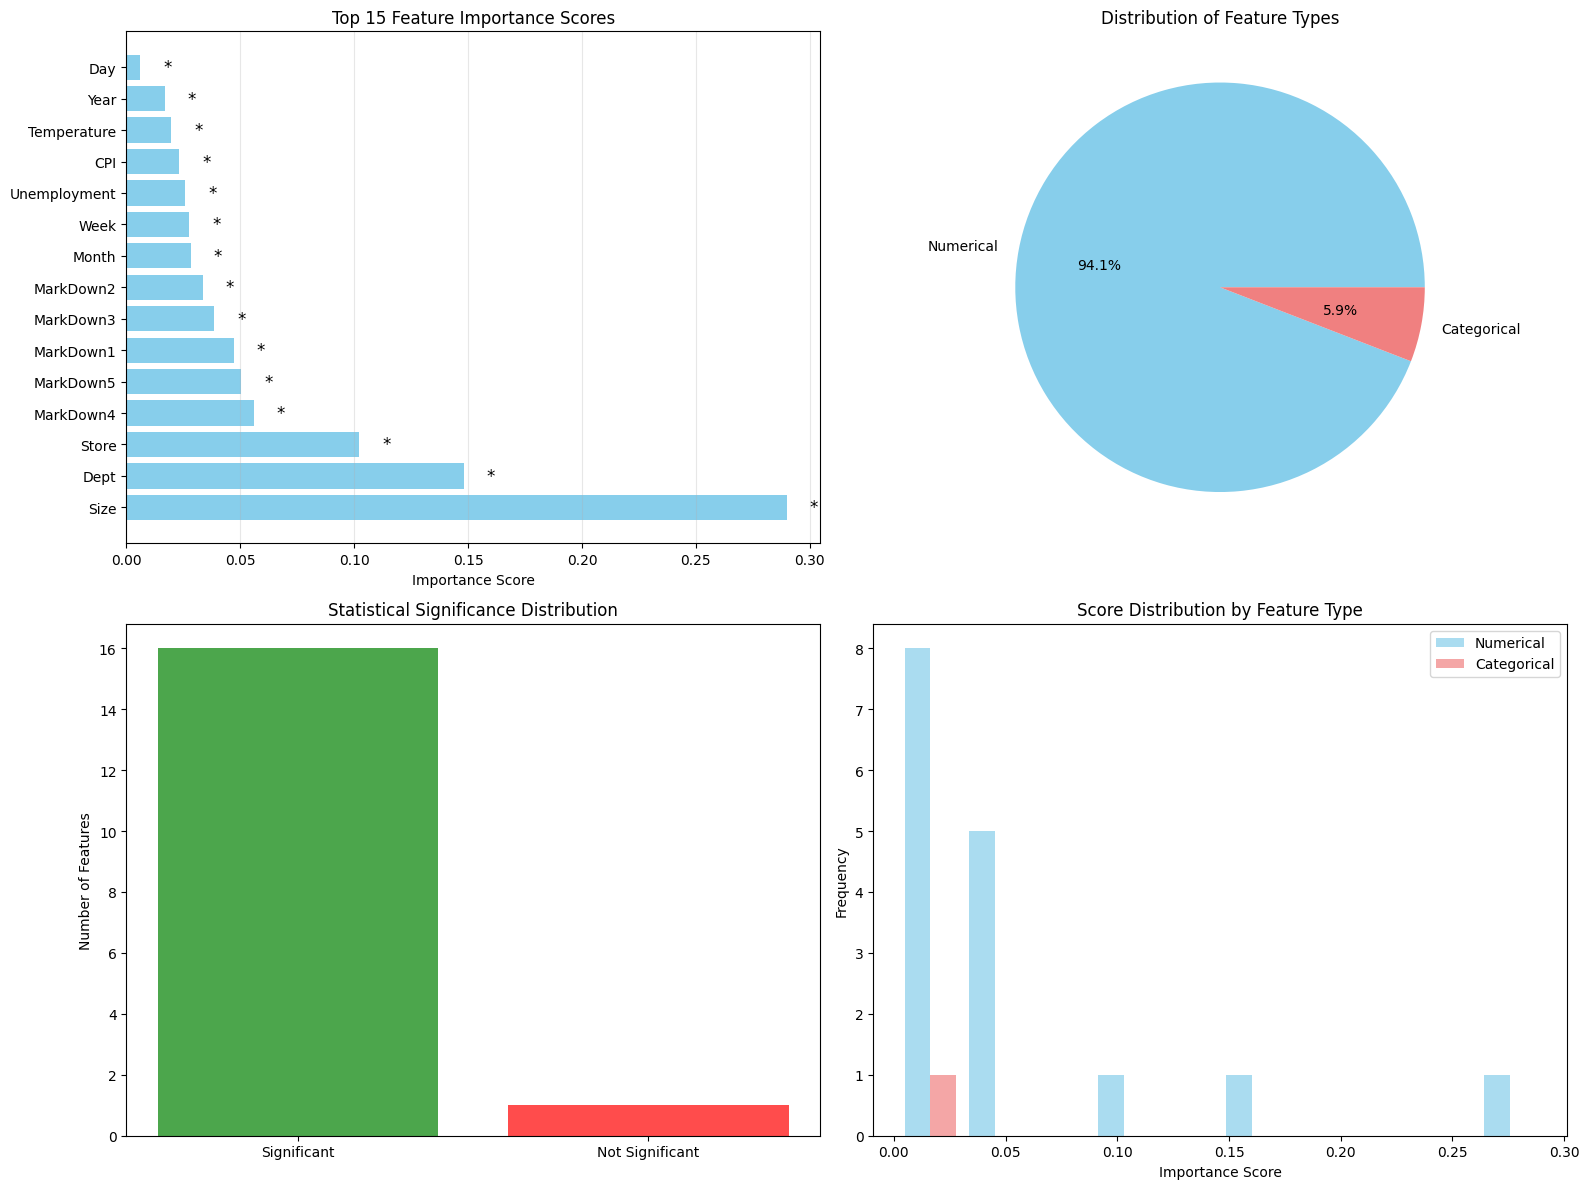


FEATURE SELECTION RESULTS
Selected top 15 features:
Number of selected features: 15
Selected features:
   1. Size            (Type: Numerical, Score: 0.290)
   2. Dept            (Type: Numerical, Score: 0.148)
   3. Store           (Type: Numerical, Score: 0.102)
   4. MarkDown4       (Type: Numerical, Score: 0.056)
   5. MarkDown5       (Type: Numerical, Score: 0.050)
   6. MarkDown1       (Type: Numerical, Score: 0.047)
   7. MarkDown3       (Type: Numerical, Score: 0.039)
   8. MarkDown2       (Type: Numerical, Score: 0.034)
   9. Month           (Type: Numerical, Score: 0.028)
  10. Week            (Type: Numerical, Score: 0.028)
  11. Unemployment    (Type: Numerical, Score: 0.026)
  12. CPI             (Type: Numerical, Score: 0.023)
  13. Temperature     (Type: Numerical, Score: 0.020)
  14. Year            (Type: Numerical, Score: 0.017)
  15. Day             (Type: Numerical, Score: 0.006)


In [22]:
results_df, feature_results = comprehensive_feature_selection(data)
create_feature_importance_visualizations(results_df)
selected_features = select_features_by_threshold(results_df, top_k=15)

# Model Evaluation

In [23]:
data['Date'] = pd.to_datetime(data['Date'])

data['Store'] = data['Store'].astype('category')
data['Dept'] = data['Dept'].astype('category')
data['Type'] = data['Type'].astype('category')

data['IsHoliday'] = data['IsHoliday'].astype(int)

data[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] = \
    data[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].fillna(0)

data['Month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
data['Month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)
data['Week_sin'] = np.sin(2 * np.pi * data['Week'] / 52)
data['Week_cos'] = np.cos(2 * np.pi * data['Week'] / 52)

data = data.sort_values('Date')
split_ratio = 0.8
split_idx = int(len(data) * split_ratio)
split_date = data['Date'].iloc[split_idx]
train_data = data[data['Date'] < split_date]
test_data = data[data['Date'] >= split_date]

num_cols = ['Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
            'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
            'Month_sin', 'Month_cos', 'Week_sin', 'Week_cos', 'Lag_1', 'Rolling_Avg_4']
cat_cols = ['Store', 'Dept', 'Type', 'IsHoliday']

In [24]:
def add_time_features(df, lag_weeks=1, rolling_window=4):
    df = df.sort_values(['Store', 'Dept', 'Date'])
    df['Lag_1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag_weeks)
    df['Rolling_Avg_4'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
        lambda x: x.rolling(rolling_window, min_periods=1, closed='left').mean()
    )
    return df

In [25]:
# Proceed with add_time_features and further processing as in original code
train_data = add_time_features(train_data.copy())
last_train_rows = train_data.groupby(['Store', 'Dept']).tail(4)
temp_data = pd.concat([last_train_rows, test_data], ignore_index=True)
temp_data = temp_data.sort_values(['Store', 'Dept', 'Date'])
test_data = add_time_features(temp_data)
test_data = test_data[test_data['Date'] >= split_date]



train_data[['Lag_1', 'Rolling_Avg_4']] = train_data[['Lag_1', 'Rolling_Avg_4']].fillna(0)
test_data[['Lag_1', 'Rolling_Avg_4']] = test_data[['Lag_1', 'Rolling_Avg_4']].fillna(0)

In [26]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

X_train = train_data[num_cols + cat_cols]
y_train = train_data['Weekly_Sales']
X_test = test_data[num_cols + cat_cols]
y_test = test_data['Weekly_Sales']

# Initialize storage for results
results = {}

## Linear Regression Model

Training Linear Regression...
LINEAR REGRESSION RESULTS

Training Metrics:
  RMSE: 7189.83
  MSE: 51693680.39
  MAE: 2607.74
  R²: 0.9014

Test Metrics:
  RMSE: 3443.62
  MSE: 11858550.14
  MAE: 1922.72
  R²: 0.9754

Overfitting Gap (Train R² - Test R²): -0.0740


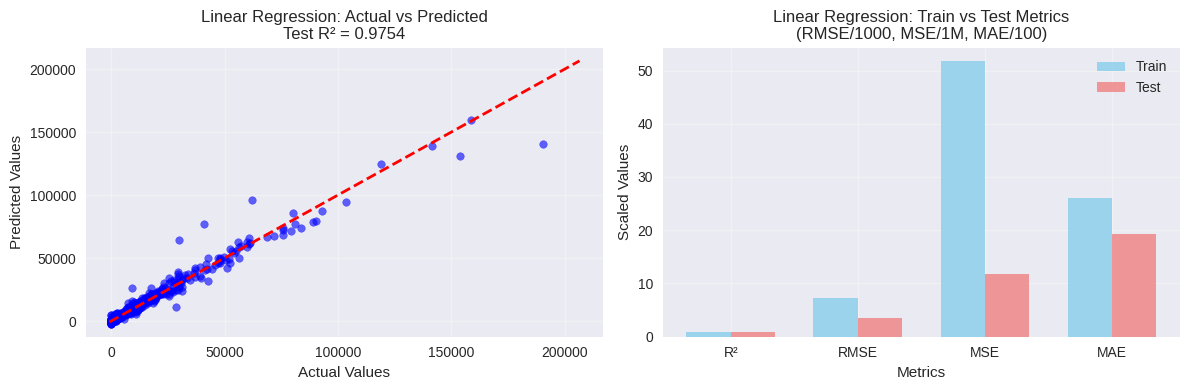

In [33]:
print("Training Linear Regression...")

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# Create and train pipeline
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
lr_y_train_pred = lr_pipeline.predict(X_train)
lr_y_test_pred = lr_pipeline.predict(X_test)

# Calculate all metrics
lr_train_rmse = np.sqrt(mean_squared_error(y_train, lr_y_train_pred))
lr_train_mse = mean_squared_error(y_train, lr_y_train_pred)
lr_train_mae = mean_absolute_error(y_train, lr_y_train_pred)
lr_train_r2 = r2_score(y_train, lr_y_train_pred)
lr_test_rmse = np.sqrt(mean_squared_error(y_test, lr_y_test_pred))
lr_test_mse = mean_squared_error(y_test, lr_y_test_pred)
lr_test_mae = mean_absolute_error(y_test, lr_y_test_pred)
lr_test_r2 = r2_score(y_test, lr_y_test_pred)

# Store results
results['Linear Regression'] = {
    'train_rmse': lr_train_rmse, 'test_rmse': lr_test_rmse,
    'train_mse': lr_train_mse, 'test_mse': lr_test_mse,
    'train_mae': lr_train_mae, 'test_mae': lr_test_mae,
    'train_r2': lr_train_r2, 'test_r2': lr_test_r2,
    'train_pred': lr_y_train_pred, 'test_pred': lr_y_test_pred,
    'overfitting_gap': lr_train_r2 - lr_test_r2
}

# Print detailed results
print("LINEAR REGRESSION RESULTS\n")
print(f"Training Metrics:")
print(f"  RMSE: {lr_train_rmse:.2f}")
print(f"  MSE: {lr_train_mse:.2f}")
print(f"  MAE: {lr_train_mae:.2f}")
print(f"  R²: {lr_train_r2:.4f}")
print(f"\nTest Metrics:")
print(f"  RMSE: {lr_test_rmse:.2f}")
print(f"  MSE: {lr_test_mse:.2f}")
print(f"  MAE: {lr_test_mae:.2f}")
print(f"  R²: {lr_test_r2:.4f}")
print(f"\nOverfitting Gap (Train R² - Test R²): {lr_train_r2 - lr_test_r2:.4f}")

# Individual model visualization
plt.figure(figsize=(12, 4))

# Actual vs Predicted
plt.subplot(1, 2, 1)
sample_idx = np.random.choice(len(y_test), size=min(500, len(y_test)), replace=False)
plt.scatter(y_test.iloc[sample_idx], lr_y_test_pred[sample_idx], alpha=0.6, s=30, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Linear Regression: Actual vs Predicted\nTest R² = {lr_test_r2:.4f}')
plt.grid(True, alpha=0.3)

# Performance metrics bar chart
plt.subplot(1, 2, 2)
metrics = ['R²', 'RMSE', 'MSE', 'MAE']
train_vals = [lr_train_r2, lr_train_rmse/1000, lr_train_mse/1000000, lr_train_mae/100]  # Scaled for visibility
test_vals = [lr_test_r2, lr_test_rmse/1000, lr_test_mse/1000000, lr_test_mae/100]

x = np.arange(len(metrics))
width = 0.35
plt.bar(x - width/2, train_vals, width, label='Train', alpha=0.8, color='skyblue')
plt.bar(x + width/2, test_vals, width, label='Test', alpha=0.8, color='lightcoral')

plt.xlabel('Metrics')
plt.ylabel('Scaled Values')
plt.title('Linear Regression: Train vs Test Metrics\n(RMSE/1000, MSE/1M, MAE/100)')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## LightGBM Model

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2411
[LightGBM] [Info] Number of data points in the train set: 55961, number of used features: 20
[LightGBM] [Info] Start training from score 17510.466478
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2886
[LightGBM] [Info] Number of data points in the train set: 111921, number of used features: 20
[LightGBM] [Info] Start training from score 18824.572638
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014801 seconds.
You can set `force_row_wise=true` to remove the overhe

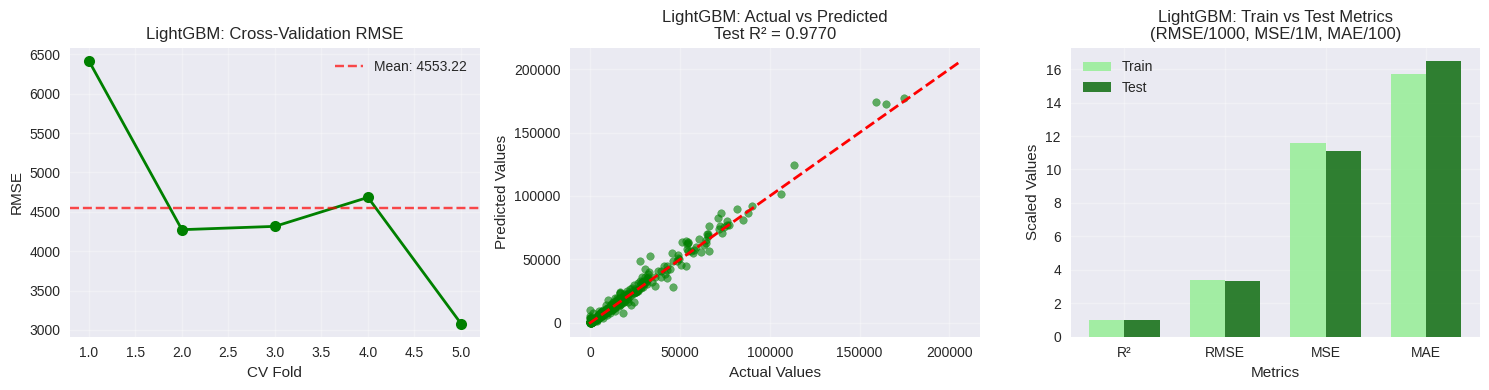

In [36]:
print("Training LightGBM...")

# Prepare LightGBM specific data
lgb_train_data = train_data[num_cols + ['Store', 'Dept', 'Type', 'IsHoliday']].copy()
lgb_test_data = test_data[num_cols + ['Store', 'Dept', 'Type', 'IsHoliday']].copy()

lgb_num_cols = num_cols
lgb_cat_cols = ['Store', 'Dept', 'Type']
lgb_passthrough_cols = ['IsHoliday']

# LightGBM preprocessing pipeline
lgb_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), lgb_num_cols),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), lgb_cat_cols),
        ('passthrough', 'passthrough', lgb_passthrough_cols)
    ])

# Create LightGBM model
categorical_feature_indices = list(range(len(lgb_num_cols), len(lgb_num_cols) + len(lgb_cat_cols)))
lgb_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=-1, num_leaves=31,
                          min_child_samples=20, random_state=42, categorical_feature=categorical_feature_indices)

lgb_pipeline = Pipeline([
    ('preprocessor', lgb_preprocessor),
    ('regressor', lgb_model)
])

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)
lgb_cv_rmse = []
for train_idx, val_idx in tscv.split(lgb_train_data):
    X_train_cv, X_val_cv = lgb_train_data.iloc[train_idx], lgb_train_data.iloc[val_idx]
    y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
    lgb_pipeline.fit(X_train_cv, y_train_cv)
    y_val_pred = lgb_pipeline.predict(X_val_cv)
    rmse = np.sqrt(mean_squared_error(y_val_cv, y_val_pred))
    lgb_cv_rmse.append(rmse)

# Train on full data
lgb_pipeline.fit(lgb_train_data, y_train)
lgb_y_train_pred = lgb_pipeline.predict(lgb_train_data)
lgb_y_test_pred = lgb_pipeline.predict(lgb_test_data)

# Calculate metrics
lgb_train_rmse = np.sqrt(mean_squared_error(y_train, lgb_y_train_pred))
lgb_train_mse = mean_squared_error(y_train, lgb_y_train_pred)
lgb_train_mae = mean_absolute_error(y_train, lgb_y_train_pred)
lgb_train_r2 = r2_score(y_train, lgb_y_train_pred)
lgb_test_rmse = np.sqrt(mean_squared_error(y_test, lgb_y_test_pred))
lgb_test_mse = mean_squared_error(y_test, lgb_y_test_pred)
lgb_test_mae = mean_absolute_error(y_test, lgb_y_test_pred)
lgb_test_r2 = r2_score(y_test, lgb_y_test_pred)

# Store results
results['LightGBM'] = {
    'train_rmse': lgb_train_rmse, 'test_rmse': lgb_test_rmse,
    'train_mse': lgb_train_mse, 'test_mse': lgb_test_mse,
    'train_mae': lgb_train_mae, 'test_mae': lgb_test_mae,
    'train_r2': lgb_train_r2, 'test_r2': lgb_test_r2,
    'train_pred': lgb_y_train_pred, 'test_pred': lgb_y_test_pred,
    'cv_rmse_mean': np.mean(lgb_cv_rmse), 'cv_rmse_std': np.std(lgb_cv_rmse),
    'overfitting_gap': lgb_train_r2 - lgb_test_r2
}

# Print detailed results
print("\nLIGHTGBM RESULTS\n")
print(f"Cross-Validation RMSE: {np.mean(lgb_cv_rmse):.2f} ± {np.std(lgb_cv_rmse):.2f}")
print(f"\nTraining Metrics:")
print(f"  RMSE: {lgb_train_rmse:.2f}")
print(f"  MSE: {lgb_train_mse:.2f}")
print(f"  MAE: {lgb_train_mae:.2f}")
print(f"  R²: {lgb_train_r2:.4f}")
print(f"\nTest Metrics:")
print(f"  RMSE: {lgb_test_rmse:.2f}")
print(f"  MSE: {lgb_test_mse:.2f}")
print(f"  MAE: {lgb_test_mae:.2f}")
print(f"  R²: {lgb_test_r2:.4f}")
print(f"\nOverfitting Gap (Train R² - Test R²): {lgb_train_r2 - lgb_test_r2:.4f}")

# Individual model visualization
plt.figure(figsize=(15, 4))

# Cross-validation performance
plt.subplot(1, 3, 1)
plt.plot(range(1, len(lgb_cv_rmse) + 1), lgb_cv_rmse, 'o-', color='green', linewidth=2, markersize=8)
plt.axhline(y=np.mean(lgb_cv_rmse), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(lgb_cv_rmse):.2f}')
plt.xlabel('CV Fold')
plt.ylabel('RMSE')
plt.title('LightGBM: Cross-Validation RMSE')
plt.legend()
plt.grid(True, alpha=0.3)

# Actual vs Predicted
plt.subplot(1, 3, 2)
sample_idx = np.random.choice(len(y_test), size=min(500, len(y_test)), replace=False)
plt.scatter(y_test.iloc[sample_idx], lgb_y_test_pred[sample_idx], alpha=0.6, s=30, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'LightGBM: Actual vs Predicted\nTest R² = {lgb_test_r2:.4f}')
plt.grid(True, alpha=0.3)

# Performance metrics bar chart
plt.subplot(1, 3, 3)
metrics = ['R²', 'RMSE', 'MSE', 'MAE']
train_vals = [lgb_train_r2, lgb_train_rmse/1000, lgb_train_mse/1000000, lgb_train_mae/100]  # Scaled for visibility
test_vals = [lgb_test_r2, lgb_test_rmse/1000, lgb_test_mse/1000000, lgb_test_mae/100]

x = np.arange(len(metrics))
width = 0.35
plt.bar(x - width/2, train_vals, width, label='Train', alpha=0.8, color='lightgreen')
plt.bar(x + width/2, test_vals, width, label='Test', alpha=0.8, color='darkgreen')

plt.xlabel('Metrics')
plt.ylabel('Scaled Values')
plt.title('LightGBM: Train vs Test Metrics\n(RMSE/1000, MSE/1M, MAE/100)')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## XGBoost Model

Training XGBoost...
XGBOOST RESULTS

Cross-Validation RMSE: 4739.92 ± 1195.67

Training Metrics:
  RMSE: 3853.77
  MSE: 14851581.75
  MAE: 1717.04
  R²: 0.9717

Test Metrics:
  RMSE: 3308.58
  MSE: 10946715.38
  MAE: 1727.96
  R²: 0.9773

Overfitting Gap (Train R² - Test R²): -0.0056


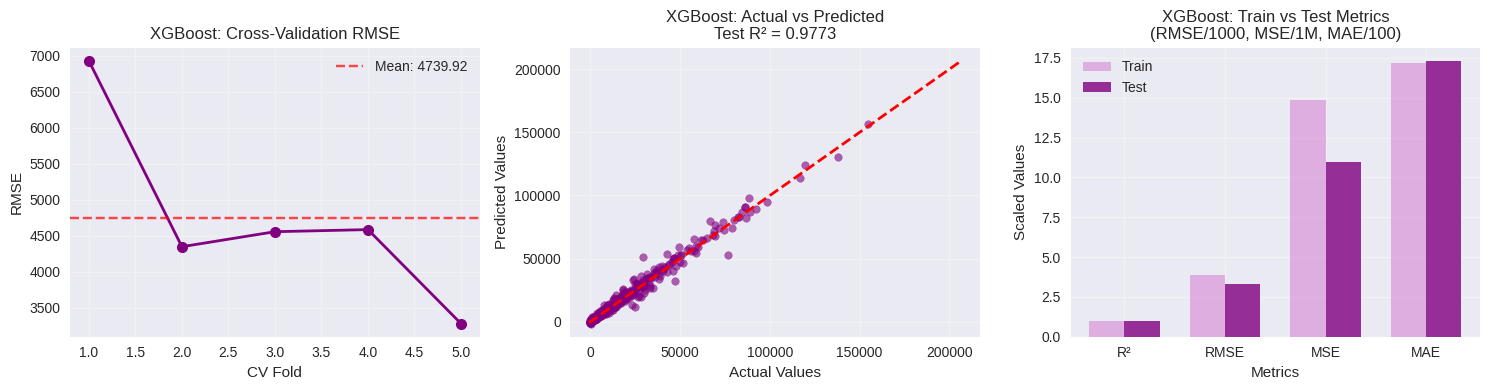

In [35]:
print("Training XGBoost...")

# Create XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1,
                        max_depth=6, random_state=42)

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

# Cross-validation
xgb_cv_rmse = []
for train_idx, val_idx in tscv.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
    xgb_pipeline.fit(X_train_cv, y_train_cv)
    y_val_pred = xgb_pipeline.predict(X_val_cv)
    rmse = np.sqrt(mean_squared_error(y_val_cv, y_val_pred))
    xgb_cv_rmse.append(rmse)

# Train on full data
xgb_pipeline.fit(X_train, y_train)
xgb_y_train_pred = xgb_pipeline.predict(X_train)
xgb_y_test_pred = xgb_pipeline.predict(X_test)

# Calculate metrics
xgb_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_y_train_pred))
xgb_train_mse = mean_squared_error(y_train, xgb_y_train_pred)
xgb_train_mae = mean_absolute_error(y_train, xgb_y_train_pred)
xgb_train_r2 = r2_score(y_train, xgb_y_train_pred)
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_y_test_pred))
xgb_test_mse = mean_squared_error(y_test, xgb_y_test_pred)
xgb_test_mae = mean_absolute_error(y_test, xgb_y_test_pred)
xgb_test_r2 = r2_score(y_test, xgb_y_test_pred)

# Store results
results['XGBoost'] = {
    'train_rmse': xgb_train_rmse, 'test_rmse': xgb_test_rmse,
    'train_mse': xgb_train_mse, 'test_mse': xgb_test_mse,
    'train_mae': xgb_train_mae, 'test_mae': xgb_test_mae,
    'train_r2': xgb_train_r2, 'test_r2': xgb_test_r2,
    'train_pred': xgb_y_train_pred, 'test_pred': xgb_y_test_pred,
    'cv_rmse_mean': np.mean(xgb_cv_rmse), 'cv_rmse_std': np.std(xgb_cv_rmse),
    'overfitting_gap': xgb_train_r2 - xgb_test_r2
}

# Print detailed results
print("XGBOOST RESULTS\n")
print(f"Cross-Validation RMSE: {np.mean(xgb_cv_rmse):.2f} ± {np.std(xgb_cv_rmse):.2f}")
print(f"\nTraining Metrics:")
print(f"  RMSE: {xgb_train_rmse:.2f}")
print(f"  MSE: {xgb_train_mse:.2f}")
print(f"  MAE: {xgb_train_mae:.2f}")
print(f"  R²: {xgb_train_r2:.4f}")
print(f"\nTest Metrics:")
print(f"  RMSE: {xgb_test_rmse:.2f}")
print(f"  MSE: {xgb_test_mse:.2f}")
print(f"  MAE: {xgb_test_mae:.2f}")
print(f"  R²: {xgb_test_r2:.4f}")
print(f"\nOverfitting Gap (Train R² - Test R²): {xgb_train_r2 - xgb_test_r2:.4f}")

# Individual model visualization
plt.figure(figsize=(15, 4))

# Cross-validation performance
plt.subplot(1, 3, 1)
plt.plot(range(1, len(xgb_cv_rmse) + 1), xgb_cv_rmse, 'o-', color='purple', linewidth=2, markersize=8)
plt.axhline(y=np.mean(xgb_cv_rmse), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(xgb_cv_rmse):.2f}')
plt.xlabel('CV Fold')
plt.ylabel('RMSE')
plt.title('XGBoost: Cross-Validation RMSE')
plt.legend()
plt.grid(True, alpha=0.3)

# Actual vs Predicted
plt.subplot(1, 3, 2)
sample_idx = np.random.choice(len(y_test), size=min(500, len(y_test)), replace=False)
plt.scatter(y_test.iloc[sample_idx], xgb_y_test_pred[sample_idx], alpha=0.6, s=30, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'XGBoost: Actual vs Predicted\nTest R² = {xgb_test_r2:.4f}')
plt.grid(True, alpha=0.3)

# Performance metrics bar chart
plt.subplot(1, 3, 3)
metrics = ['R²', 'RMSE', 'MSE', 'MAE']
train_vals = [xgb_train_r2, xgb_train_rmse/1000, xgb_train_mse/1000000, xgb_train_mae/100]  # Scaled for visibility
test_vals = [xgb_test_r2, xgb_test_rmse/1000, xgb_test_mse/1000000, xgb_test_mae/100]

x = np.arange(len(metrics))
width = 0.35
plt.bar(x - width/2, train_vals, width, label='Train', alpha=0.8, color='plum')
plt.bar(x + width/2, test_vals, width, label='Test', alpha=0.8, color='purple')

plt.xlabel('Metrics')
plt.ylabel('Scaled Values')
plt.title('XGBoost: Train vs Test Metrics\n(RMSE/1000, MSE/1M, MAE/100)')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparing Metrics and Results

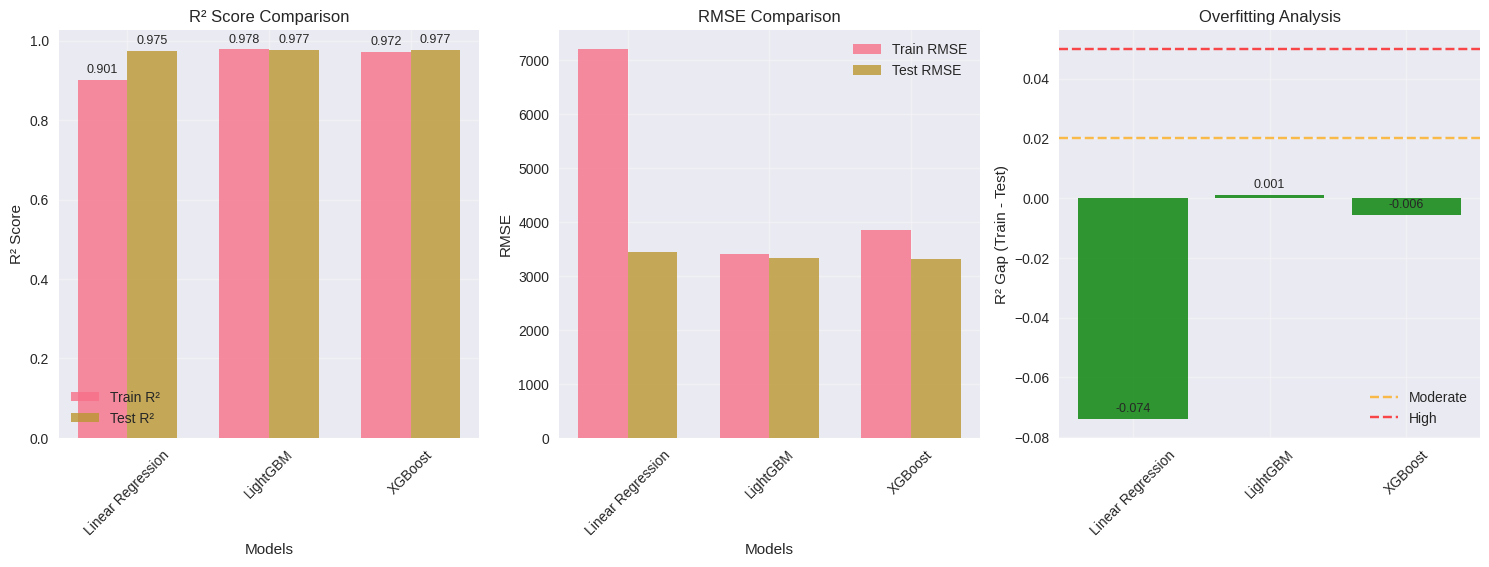

In [37]:
models = list(results.keys())
fig = plt.figure(figsize=(15, 10))

# R² Score Comparison
ax1 = plt.subplot(2, 3, 1)
train_r2 = [results[model]['train_r2'] for model in models]
test_r2 = [results[model]['test_r2'] for model in models]

x = np.arange(len(models))
width = 0.35
bars1 = ax1.bar(x - width/2, train_r2, width, label='Train R²', alpha=0.8)
bars2 = ax1.bar(x + width/2, test_r2, width, label='Test R²', alpha=0.8)

ax1.set_xlabel('Models')
ax1.set_ylabel('R² Score')
ax1.set_title('R² Score Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# RMSE Comparison
ax2 = plt.subplot(2, 3, 2)
train_rmse = [results[model]['train_rmse'] for model in models]
test_rmse = [results[model]['test_rmse'] for model in models]

bars1 = ax2.bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8)
bars2 = ax2.bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8)

ax2.set_xlabel('Models')
ax2.set_ylabel('RMSE')
ax2.set_title('RMSE Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Overfitting Gap Analysis
ax3 = plt.subplot(2, 3, 3)
overfitting_gaps = [results[model]['overfitting_gap'] for model in models]
bars = ax3.bar(models, overfitting_gaps, alpha=0.8,
               color=['red' if gap > 0.05 else 'orange' if gap > 0.02 else 'green' for gap in overfitting_gaps])
ax3.set_ylabel('R² Gap (Train - Test)')
ax3.set_title('Overfitting Analysis')
ax3.set_xticklabels(models, rotation=45)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0.02, color='orange', linestyle='--', alpha=0.7, label='Moderate')
ax3.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='High')
ax3.legend()

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

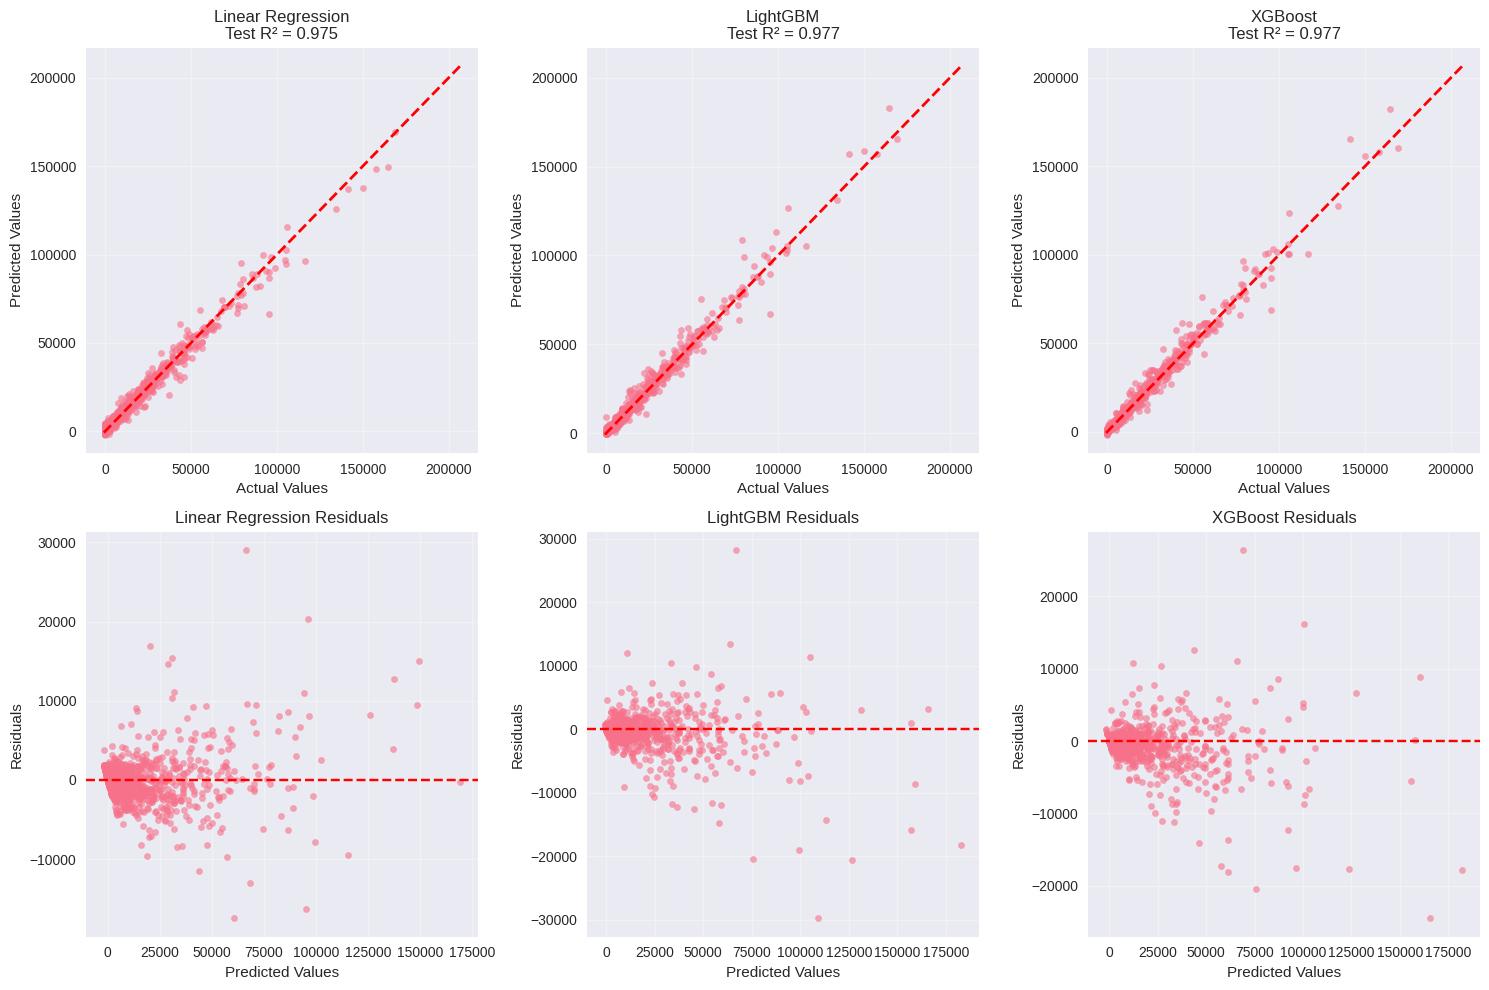

In [38]:
fig = plt.figure(figsize=(15, 10))
sample_idx = np.random.choice(len(y_test), size=min(1000, len(y_test)), replace=False)

# Actual vs Predicted plots for each model
for i, model in enumerate(models):
    ax = plt.subplot(2, 3, i+1)
    pred_values = results[model]['test_pred']
    ax.scatter(y_test.iloc[sample_idx], pred_values[sample_idx], alpha=0.6, s=20)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'{model}\nTest R² = {results[model]["test_r2"]:.3f}')
    ax.grid(True, alpha=0.3)

# Residuals plots for each model
for i, model in enumerate(models):
    ax = plt.subplot(2, 3, i+4)
    pred_values = results[model]['test_pred']
    residuals = y_test.iloc[sample_idx] - pred_values[sample_idx]
    ax.scatter(pred_values[sample_idx], residuals, alpha=0.6, s=20)
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    ax.set_title(f'{model} Residuals')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [41]:
data_rows = []
for model in models:
    row = {
        'Model': model,
        'Train_R²': results[model]['train_r2'],
        'Test_R²': results[model]['test_r2'],
        'Train_RMSE': results[model]['train_rmse'],
        'Test_RMSE': results[model]['test_rmse'],
        'Train_MSE': results[model]['train_mse'],
        'Test_MSE': results[model]['test_mse'],
        'Train_MAE': results[model]['train_mae'],
        'Test_MAE': results[model]['test_mae'],
        'Overfitting_Gap': results[model]['overfitting_gap']
    }
    data_rows.append(row)

# Create the DataFrame from the list of dictionaries
comparison_df = pd.DataFrame(data_rows)

# Round for better display
numerical_cols = ['Train_R²', 'Test_R²', 'Train_RMSE', 'Test_RMSE', 'Train_MSE', 'Test_MSE', 'Train_MAE', 'Test_MAE', 'Overfitting_Gap']
comparison_df[numerical_cols] = comparison_df[numerical_cols].round(4)

print("DETAILED MODEL COMPARISON")
print(comparison_df.to_string(index=False))

# Summary and recommendations
best_test_r2_model = max(models, key=lambda x: results[x]['test_r2'])
lowest_overfitting_model = min(models, key=lambda x: results[x]['overfitting_gap'])
best_test_rmse_model = min(models, key=lambda x: results[x]['test_rmse'])

print(f"\nSUMMARY")
print(f"Best Test R²: {best_test_r2_model} ({results[best_test_r2_model]['test_r2']:.4f})")
print(f"Best Test RMSE: {best_test_rmse_model} ({results[best_test_rmse_model]['test_rmse']:.2f})")
print(f"Lowest Overfitting: {lowest_overfitting_model} (Gap: {results[lowest_overfitting_model]['overfitting_gap']:.4f})")

print(f"\nPerformance Analysis:")
for model in models:
    gap = results[model]['overfitting_gap']
    if gap < 0.02:
        status = "Low overfitting"
    elif gap < 0.05:
        status = "Moderate overfitting"
    else:
        status = "High overfitting"

    print(f"  {model}: {status} | Test R²: {results[model]['test_r2']:.4f} | Test RMSE: {results[model]['test_rmse']:.2f}")

print(f"\nRecommendation:")
if results[best_test_r2_model]['overfitting_gap'] < 0.05:
    print(f"  {best_test_r2_model} shows the best overall performance with good generalization")
else:
    print(f"  {best_test_r2_model} has the best test performance but shows overfitting")
    print(f"  Consider {lowest_overfitting_model} for better generalization")

DETAILED MODEL COMPARISON
            Model  Train_R²  Test_R²  Train_RMSE  Test_RMSE    Train_MSE     Test_MSE  Train_MAE  Test_MAE  Overfitting_Gap
Linear Regression    0.9014   0.9754   7189.8317  3443.6246 5.169368e+07 1.185855e+07  2607.7426 1922.7214          -0.0740
         LightGBM    0.9779   0.9770   3401.5277  3331.9435 1.157039e+07 1.110185e+07  1571.0999 1645.8001           0.0010
          XGBoost    0.9717   0.9773   3853.7750  3308.5821 1.485158e+07 1.094672e+07  1717.0418 1727.9584          -0.0056

SUMMARY
Best Test R²: XGBoost (0.9773)
Best Test RMSE: XGBoost (3308.58)
Lowest Overfitting: Linear Regression (Gap: -0.0740)

Performance Analysis:
  Linear Regression: Low overfitting | Test R²: 0.9754 | Test RMSE: 3443.62
  LightGBM: Low overfitting | Test R²: 0.9770 | Test RMSE: 3331.94
  XGBoost: Low overfitting | Test R²: 0.9773 | Test RMSE: 3308.58

Recommendation:
  XGBoost shows the best overall performance with good generalization
